In [114]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile

import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy import linalg as LA

# Introduction

We want to study the Hamiltonian of the anti-ferromagnetic Heinsenberg model for a "bow-tie" lattice with zero field. The hamiltonian is given by:

$$ H=\sum_{\langle i,j \rangle} \{X_i X_j+Y_iY_j+Z_iZ_j\}$$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i$ and $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$.

In the following we define the functions useful to define our Hamiltonian.

In [115]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin



In [116]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [117]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

**Definition of the isotropic Heisenberg Hamiltonian on the bow-tie lattice** 

In [118]:
nqubit  = 5
nn_list = [(0,1),(1,2),(0,2),(2,3),(2,4),(3,4)]
H       = generate_Heisenberg(nqubit,nn_list)

mat_H = H.to_matrix()
print(mat_H)

[[6.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 6.+0.j]]


**Definition of $S_x,S_y,S_z,S^2$**

In [119]:
sx=[]
for i in range (nqubit):
    sx.append((1.0/2.,generate_pauli([i],[],nqubit)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (nqubit):
    sy.append((1.0/2.,generate_pauli([i],[i],nqubit)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

sz=[]
for i in range (nqubit):
    sz.append((1.0/2.,generate_pauli([],[i],nqubit)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
#print("Sz operator matrix")
#print(mat_sz)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
#print("S2 operator")
#print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
#print("S2 operator matrix")
#print(mat_s2)

Sx operator
IIIIX	(0.5+0j)
IIIXI	(0.5+0j)
IIXII	(0.5+0j)
IXIII	(0.5+0j)
XIIII	(0.5+0j)

Sy operator
IIIIY	(0.5+0j)
IIIYI	(0.5+0j)
IIYII	(0.5+0j)
IYIII	(0.5+0j)
YIIII	(0.5+0j)

Sz operator
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)
IIZII	(0.5+0j)
IZIII	(0.5+0j)
ZIIII	(0.5+0j)



# Anisotropic Heisenberg Hamiltonian in the bow-tie lattice

The idea is to study a given Hamiltonian $H$ which doesn't commute with $S$. Otherwise we could describe all the eigenstates of $H$ using the total spin.

In [120]:
# We give a vector with the coupling constants
def anisotropic_Heisenberg(nqubit,nn_list,coef):
    pauli_list = []
    for idx,(i,j) in enumerate(nn_list):
        xixj = PauliOp(generate_pauli([i,j],[],nqubit),coef[idx]);    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit),coef[idx]); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit),coef[idx]);    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

## Isosceles case

We are going to talk about the following Hamiltonian.

$$H=J'\hat{S}_{0}\cdot\hat{S}_{1} + J\hat{S}_{0}\cdot\hat{S}_{2} + J\hat{S}_{1}\cdot\hat{S}_{2} + J\hat{S}_{2}\cdot\hat{S}_{3} + J\hat{S}_{2}\cdot\hat{S}_{4} + J'\hat{S}_{0}\cdot\hat{S}_{1}$$

We remind that we are working with a "bow-tie" lattice. 

Text(0, 0.5, 'y')

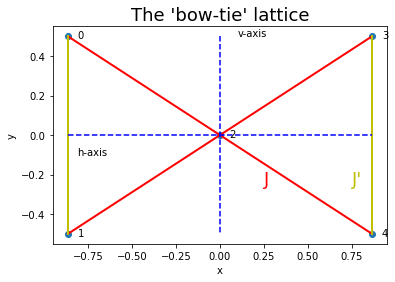

In [121]:
# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))
plt.annotate("h-axis",(-0.866,0),xytext=(-0.866+0.055,0-0.1))
plt.annotate("v-axis",(0,0.5),xytext=(0+0.1,0.5))
plt.annotate("J",(0.25,-0.25),xytext=(0.25,-0.25),color="r",size=18)
plt.annotate("J'",(0.75,-0.25),xytext=(0.75,-0.25),color="y",size=18)

# Nearest-neighbors coupling
plt.plot([-0.866,0,0.866],[-0.5,0,0.5],"r",linewidth="2")
plt.plot([-0.866,0,0.866],[0.5,0,-0.5],"r",linewidth="2")
plt.plot([-0.866,-0.866],[-0.5,0.5],"y",linewidth="2")
plt.plot([0.866,0.866],[-0.5,0.5],"y",linewidth="2")


# Axes
plt.plot([-0.866,0.866],[0,0],"b--")
plt.plot([0,0],[0.5,-0.5],"b--")

    
plt.title("The 'bow-tie' lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

#### $[H,S]=0$ ?

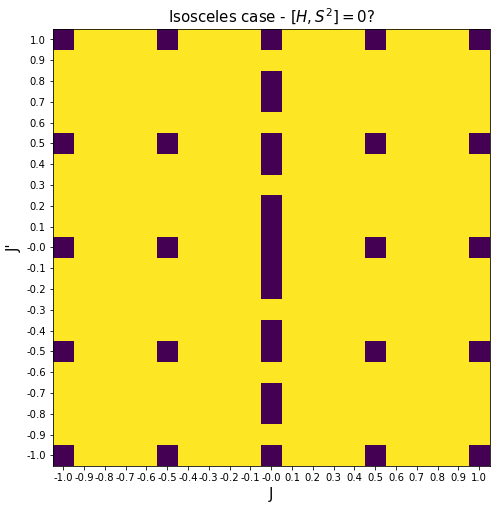

In [122]:
val=np.round(np.arange(-1.,1+1e-4,0.1),2)
M=np.zeros((len(val),len(val)))
for i in range(len(val)):
    for j in range(len(val)):
            coef=[val[i],val[j],val[j],val[j],val[j],val[i]]
            H_an=anisotropic_Heisenberg(nqubit,nn_list,coef)
            mat_H_an=H_an.to_matrix()
             
            if np.all(np.dot(mat_H_an,mat_s2)==np.dot(mat_s2,mat_H_an)):
                M[len(val)-1-i,j]=0
            else:
                M[len(val)-1-i,j]=1
            
fig, ax = plt.subplots(figsize=(7,14))
im = ax.imshow(M)       
ax.set_xticks(np.arange(len(val)))
ax.set_yticks(np.arange(len(val)))
ax.set_xticklabels(np.round(val,2), fontsize=10)
ax.set_yticklabels(np.round(val[::-1],2), fontsize=10)

ax.set_xlabel("J",fontsize=15)
ax.set_ylabel("J'",fontsize=15)
        
#fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

ax.set_title("Isosceles case - $[H,S^2]=0$?", fontsize=15)
fig.tight_layout()
plt.show()

Purple squares indicate that the Hamiltonian commutes with the total spin. We remind that in this case a negative coupling constant refers to the ferromagnetic case, therefore we have to look at the up-right region.

#### Heisenberg Hamiltonian eigenvalues for the isosceles case

In [123]:
spins=generate_spin_operators(nqubit)
eig_bti=[]
comm_bti=[1]*9

c=0
for i in [0.8,0.9,1.0]:
    for j in [0.8,0.9,1.0]:
        coef=[i,j,j,j,j,i]
        H_bti=anisotropic_Heisenberg(nqubit,nn_list,coef)
        mat_H_bti=H_bti.to_matrix()
        if np.all(np.dot(mat_H_bti,mat_s2)==np.dot(mat_s2,mat_H_bti)):
                comm_bti[c]=0
        out_bti=diagonalize_H(H_bti,spins)
        eig_bti.append(out_bti[0])
        c+=1

2021-02-10 15:53:51,070:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:51,261:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.07081304762903348, 0],
       [0.0, 0],
       [-0.5021060937510472, 0],
       [-0.421931508092845, 0],
       [0.0, 0],
       [-0.5455417038037074, 0],
       [0.0880931647357604, 0],
       [0.0, 0],
       [0.3127313728260226, 0],
       [-0.01426393127115514, 0],
       [0.0, 0],
       [-0.09516395116402177, 0],
       [0.08616675898245622, 0],
       [0.0, 0],
       [-0.024440813339380904, 0]], dtype=object),
                   array([[0.08760336071518328, 0],
       [0.0, 0],
       [-0.19696157391940755, 0],
       [-0.14878742879211265, 0],
       [0.0, 0],
       [0.20625486486797912, 0],
       [0.3448760071954555, 0],
       [0.0, 0],
       [0.8097202608552476, 0],
       [0

2021-02-10 15:53:51,319:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.07081304762903348, 0],
       [0.0, 0],
       [-0.5021060937510472, 0],
       [-0.421931508092845, 0],
       [0.0, 0],
       [-0.5455417038037074, 0],
       [0.0880931647357604, 0],
       [0.0, 0],
       [0.3127313728260226, 0],
       [-0.01426393127115514, 0],
       [0.0, 0],
       [-0.09516395116402177, 0],
       [0.08616675898245622, 0],
       [0.0, 0],
       [-0.024440813339380904, 0]], dtype=object),
                                    array([[0.08760336071518328, 0],
       [0.0, 0],
       [-0.19696157391940755, 0],
       [-0.14878742879211265, 0],
       [0.0, 0],
       [0.20625486486797912, 0],
       [0.3448760071954555, 0],
       [0.0, 0],
       [0.8097202608552476, 0],
       [0.04400284777999054, 0],
       [0.0, 0],
       [-0.24914038179272635, 0],
       [-0.12026386861204877, 0],
       [0.0, 0],


2021-02-10 15:53:51,346:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:51,536:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.007744781413849843, 0],
       [0.0, 0],
       [0.010289076902403327, 0],
       [-0.007744781413847506, 0],
       [0.0, 0],
       [0.010289076902403216, 0],
       [0.01550179451435904, 0],
       [0.0, 0],
       [-0.3318318708639105, 0],
       [-0.023258807614868947, 0],
       [0.0, 0],
       [0.6533746648254142, 0],
       [-0.02325880761486852, 0],
       [0.0, 0],
       [0.6533746648254213, 0]], dtype=object),
                   array([[-0.014091055903919894, 0],
       [0.0, 0],
       [0.04927184983813537, 0],
       [-0.014091055903919278, 0],
       [0.0, 0],
       [0.04927184983813604, 0],
       [0.01136569888424925, 0],
       [0.0, 0],
       [0.28304349186287964, 0],


2021-02-10 15:53:51,597:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.007744781413849843, 0],
       [0.0, 0],
       [0.010289076902403327, 0],
       [-0.007744781413847506, 0],
       [0.0, 0],
       [0.010289076902403216, 0],
       [0.01550179451435904, 0],
       [0.0, 0],
       [-0.3318318708639105, 0],
       [-0.023258807614868947, 0],
       [0.0, 0],
       [0.6533746648254142, 0],
       [-0.02325880761486852, 0],
       [0.0, 0],
       [0.6533746648254213, 0]], dtype=object),
                                    array([[-0.014091055903919894, 0],
       [0.0, 0],
       [0.04927184983813537, 0],
       [-0.014091055903919278, 0],
       [0.0, 0],
       [0.04927184983813604, 0],
       [0.01136569888424925, 0],
       [0.0, 0],
       [0.28304349186287964, 0],
       [-0.008640341864579404, 0],
       [0.0, 0],
       [-0.6153588335638953, 0],
       [-0.008640341864578974, 0],
      

2021-02-10 15:53:51,619:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:51,773:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.0539557533788625, 0],
       [0.0, 0],
       [-0.3134086627399822, 0],
       [-0.053955753378862825, 0],
       [0.0, 0],
       [-0.31340866273998236, 0],
       [0.07263440753946365, 0],
       [0.0, 0],
       [0.3249429855075898, 0],
       [-0.09131306170006484, 0],
       [0.0, 0],
       [-0.33647730827519695, 0],
       [-0.0913130617000652, 0],
       [0.0, 0],
       [-0.3364773082751968, 0]], dtype=object),
                   array([[-0.11572595368163653, 0],
       [0.0, 0],
       [0.027088733630206807, 0],
       [-0.1157259536816361, 0],
       [0.0, 0],
       [0.02708873363020886, 0],
       [-0.09733947314559213, 0],
       [0.0, 0],
       [0.21214757588193495, 0],
    

2021-02-10 15:53:51,828:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.0539557533788625, 0],
       [0.0, 0],
       [-0.3134086627399822, 0],
       [-0.053955753378862825, 0],
       [0.0, 0],
       [-0.31340866273998236, 0],
       [0.07263440753946365, 0],
       [0.0, 0],
       [0.3249429855075898, 0],
       [-0.09131306170006484, 0],
       [0.0, 0],
       [-0.33647730827519695, 0],
       [-0.0913130617000652, 0],
       [0.0, 0],
       [-0.3364773082751968, 0]], dtype=object),
                                    array([[-0.11572595368163653, 0],
       [0.0, 0],
       [0.027088733630206807, 0],
       [-0.1157259536816361, 0],
       [0.0, 0],
       [0.02708873363020886, 0],
       [-0.09733947314559213, 0],
       [0.0, 0],
       [0.21214757588193495, 0],
       [0.31040489997282006, 0],
       [0.0, 0],
       [-0.45138388539407637, 0],
       [0.3104048999728215, 0],
       [0.0, 0

2021-02-10 15:53:51,850:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:52,006:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5100986639604465, 0],
       [0.0, 0],
       [-0.8601158951128431, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.0003588444053719741, 0],
       [0.0, 0],
       [0.9999999356153442, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.07015263793982389, 0],
       [0.0, 0],
       [0.6478

2021-02-10 15:53:52,077:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5100986639604465, 0],
       [0.0, 0],
       [-0.8601158951128431, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.0003588444053719741, 0],
       [0.0, 0],
       [0.9999999356153442, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[-0.07015263793982389, 0],
       [0.0, 0],
       [0.6478508299272114, 0],
       [-0.07015263793981444, 0],
       [0.0, 0],
       [0.6478508299272145, 0],
       [

2021-02-10 15:53:52,097:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:52,253:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0317427883855569, 0],
       [0.0, 0],
       [0.3034368186052625, 0],
       [0.1178967640483347, 0],
       [0.0, 0],
       [-0.5096362709027211, 0],
       [-0.3032671593041697, 0],
       [0.0, 0],
       [-0.4973388010931115, 0],
       [0.0750490803875832, 0],
       [0.0, 0],
       [0.25616465965684415, 0],
       [-0.07348469886920507, 0],
       [0.0, 0],
       [-0.4600750689948707, 0]], dtype=object),
                   array([[0.8485569138529576, 0],
       [0.0, 0],
       [0.48100693520022836, 0],
       [0.07734705839077047, 0],
       [0.0, 0],
       [-0.10454084315176383, 0],
       [-0.08353710355926529, 0],
       [0.0, 0],
       [0.09419988619403916, 0],
       [-0.05

2021-02-10 15:53:52,324:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0317427883855569, 0],
       [0.0, 0],
       [0.3034368186052625, 0],
       [0.1178967640483347, 0],
       [0.0, 0],
       [-0.5096362709027211, 0],
       [-0.3032671593041697, 0],
       [0.0, 0],
       [-0.4973388010931115, 0],
       [0.0750490803875832, 0],
       [0.0, 0],
       [0.25616465965684415, 0],
       [-0.07348469886920507, 0],
       [0.0, 0],
       [-0.4600750689948707, 0]], dtype=object),
                                    array([[0.8485569138529576, 0],
       [0.0, 0],
       [0.48100693520022836, 0],
       [0.07734705839077047, 0],
       [0.0, 0],
       [-0.10454084315176383, 0],
       [-0.08353710355926529, 0],
       [0.0, 0],
       [0.09419988619403916, 0],
       [-0.05611721149015745, 0],
       [0.0, 0],
       [0.04670194039386824, 0],
       [0.03816422344955137, 0],
       [0.0, 0],
     

2021-02-10 15:53:52,349:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:52,504:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.2616670053612937, 0],
       [0.0, 0],
       [-0.1019559412896538, 0],
       [0.26166700536129617, 0],
       [0.0, 0],
       [-0.10195594128965554, 0],
       [-0.21422085758350903, 0],
       [0.0, 0],
       [-0.12298847856312631, 0],
       [0.16677470980572479, 0],
       [0.0, 0],
       [0.3479328984159077, 0],
       [0.1667747098057216, 0],
       [0.0, 0],
       [0.3479328984159077, 0]], dtype=object),
                   array([[0.002611372477228038, 0],
       [0.0, 0],
       [0.061917292956395364, 0],
       [0.0026113724772272233, 0],
       [0.0, 0],
       [0.06191729295639492, 0],
       [0.09227548187494022, 0],
       [0.0, 0],
       [0.2565415680433397, 0],
       [-

2021-02-10 15:53:52,564:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.2616670053612937, 0],
       [0.0, 0],
       [-0.1019559412896538, 0],
       [0.26166700536129617, 0],
       [0.0, 0],
       [-0.10195594128965554, 0],
       [-0.21422085758350903, 0],
       [0.0, 0],
       [-0.12298847856312631, 0],
       [0.16677470980572479, 0],
       [0.0, 0],
       [0.3479328984159077, 0],
       [0.1667747098057216, 0],
       [0.0, 0],
       [0.3479328984159077, 0]], dtype=object),
                                    array([[0.002611372477228038, 0],
       [0.0, 0],
       [0.061917292956395364, 0],
       [0.0026113724772272233, 0],
       [0.0, 0],
       [0.06191729295639492, 0],
       [0.09227548187494022, 0],
       [0.0, 0],
       [0.2565415680433397, 0],
       [-0.18716233622710626, 0],
       [0.0, 0],
       [-0.575000429043076, 0],
       [-0.18716233622710973, 0],
       [0.0, 0],
 

2021-02-10 15:53:52,587:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:52,747:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.036166617492237915, 0],
       [0.0, 0],
       [0.9993457738836793, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.1311170358678707, 0],
       [0.0, 0],
       [-0.9913668962121056, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.00019940736714142314, 0],
       [0.0, 0],
       [0.00

2021-02-10 15:53:52,802:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.036166617492237915, 0],
       [0.0, 0],
       [0.9993457738836793, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.1311170358678707, 0],
       [0.0, 0],
       [-0.9913668962121056, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[-0.00019940736714142314, 0],
       [0.0, 0],
       [0.00027718703302875847, 0],
       [-0.00019940736714163222, 0],
       [0.0, 0],
       [0.0002771870330279258, 

2021-02-10 15:53:52,822:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:52,975:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.044401854080315606, 0],
       [0.0, 0],
       [-0.9990137513338994, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.20287543406423536, 0],
       [0.0, 0],
       [0.9792045538360452, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.10194918630029645, 0],
       [0.0, 0],
       [0.64133

2021-02-10 15:53:53,030:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.044401854080315606, 0],
       [0.0, 0],
       [-0.9990137513338994, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.20287543406423536, 0],
       [0.0, 0],
       [0.9792045538360452, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[-0.10194918630029645, 0],
       [0.0, 0],
       [0.6413314291585248, 0],
       [-0.10194918630029635, 0],
       [0.0, 0],
       [0.6413314291585264, 0],
       [0

2021-02-10 15:53:53,053:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:53,212:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0354267079894726, 0],
       [0.0, 0],
       [0.8190795755315219, 0],
       [-4.580502133144648e-08, 0],
       [0.0, 0],
       [-0.30308873242631357, 0],
       [-0.011539680605977513, 0],
       [0.0, 0],
       [0.47959134126158404, 0],
       [-0.018499672323957647, 0],
       [0.0, 0],
       [0.04588904283559047, 0],
       [0.01599528241971001, 0],
       [0.0, 0],
       [-0.04311337150459968, 0]], dtype=object),
                   array([[0.06137121469142622, 0],
       [0.0, 0],
       [-0.18061070748735852, 0],
       [0.2215569556693856, 0],
       [0.0, 0],
       [0.5570317547516015, 0],
       [-0.10472032560966352, 0],
       [0.0, 0],
       [0.09082226115847639, 0],
    

2021-02-10 15:53:53,267:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0354267079894726, 0],
       [0.0, 0],
       [0.8190795755315219, 0],
       [-4.580502133144648e-08, 0],
       [0.0, 0],
       [-0.30308873242631357, 0],
       [-0.011539680605977513, 0],
       [0.0, 0],
       [0.47959134126158404, 0],
       [-0.018499672323957647, 0],
       [0.0, 0],
       [0.04588904283559047, 0],
       [0.01599528241971001, 0],
       [0.0, 0],
       [-0.04311337150459968, 0]], dtype=object),
                                    array([[0.06137121469142622, 0],
       [0.0, 0],
       [-0.18061070748735852, 0],
       [0.2215569556693856, 0],
       [0.0, 0],
       [0.5570317547516015, 0],
       [-0.10472032560966352, 0],
       [0.0, 0],
       [0.09082226115847639, 0],
       [-0.15281626693857797, 0],
       [0.0, 0],
       [0.5824480793277407, 0],
       [0.028419008576016418, 0],
       [0.0, 

In [124]:
c=0
print("Eigenvalues of H(J,J') s.t. [H,S]!=0","\n")
for i in [0.8,0.9,1.0]:
    for j in [0.8,0.9,1.0]:
        if comm_bti[c]==1:
            print("J =",j,", J' =",i," : ",np.round(eig_bti[c],2))
        c+=1

Eigenvalues of H(J,J') s.t. [H,S]!=0 

J = 0.8 , J' = 0.8  :  [-4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -3.2 -3.2 -3.2 -3.2 -1.6 -1.6 -0.  -0.
 -0.  -0.  -0.   0.   0.   0.   1.6  1.6  3.2  3.2  3.2  3.2  4.8  4.8
  4.8  4.8  4.8  4.8]
J = 0.9 , J' = 0.8  :  [-5.2 -5.2 -5.2 -5.2 -4.8 -4.8 -3.8 -3.8 -3.8 -3.8 -2.  -2.   0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  1.6  1.6  3.4  3.4  3.4  3.4  5.2  5.2
  5.2  5.2  5.2  5.2]
J = 1.0 , J' = 0.8  :  [-5.6 -5.6 -5.6 -5.6 -4.8 -4.8 -4.4 -4.4 -4.4 -4.4 -2.4 -2.4  0.4  0.4
  0.4  0.4  0.4  0.4  0.4  0.4  1.6  1.6  3.6  3.6  3.6  3.6  5.6  5.6
  5.6  5.6  5.6  5.6]
J = 0.8 , J' = 0.9  :  [-5.4 -5.4 -5.  -5.  -5.  -5.  -3.  -3.  -3.  -3.  -1.4 -1.4 -0.2 -0.2
 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2  1.8  1.8  3.4  3.4  3.4  3.4  5.   5.
  5.   5.   5.   5. ]
J = 0.9 , J' = 0.9  :  [-5.4 -5.4 -5.4 -5.4 -5.4 -5.4 -3.6 -3.6 -3.6 -3.6 -1.8 -1.8 -0.  -0.
 -0.   0.   0.   0.   0.   0.   1.8  1.8  3.6  3.6  3.6  3.6  5.4  5.4
  5.4  5.4  5.4  5.4]
J = 1.0 , J' = 0.9  :  [-5.8 

## Scalene case

Text(0, 0.5, 'y')

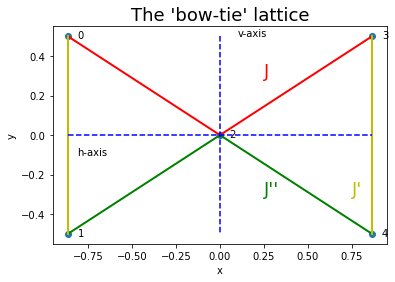

In [125]:
# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))
plt.annotate("h-axis",(-0.866,0),xytext=(-0.866+0.055,0-0.1))
plt.annotate("v-axis",(0,0.5),xytext=(0+0.1,0.5))
plt.annotate("J''",(0.25,-0.25),xytext=(0.25,-0.3),color="g",size=18)
plt.annotate("J'",(0.75,-0.25),xytext=(0.75,-0.3),color="y",size=18)
plt.annotate("J",(0.25,0.3),xytext=(0.25,0.3),color="r",size=18)

# Nearest-neighbors coupling
plt.plot([-0.866,0,0.866],[0.5,0,0.5],"r",linewidth="2")
plt.plot([-0.866,0,0.866],[-0.5,0,-0.5],"g",linewidth="2")
plt.plot([-0.866,-0.866],[-0.5,0.5],"y",linewidth="2")
plt.plot([0.866,0.866],[-0.5,0.5],"y",linewidth="2")


# Axes
plt.plot([-0.866,0.866],[0,0],"b--")
plt.plot([0,0],[0.5,-0.5],"b--")

    
plt.title("The 'bow-tie' lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

#### Heisenberg Hamiltonian eigenvalues for the scalene case

In [126]:
eig_bts=[]
comm_bts=[1]*27

c=0
for i in [0.8,0.9,1.0]:
    for j in [0.8,0.9,1.0]:
        for k in [0.8,0.9,1.0]:
            coef=[i,k,j,j,k,i]
            H_bts=anisotropic_Heisenberg(nqubit,nn_list,coef)
            mat_H_bts=H_bts.to_matrix()
            if np.all(np.dot(mat_H_bts,mat_s2)==np.dot(mat_s2,mat_H_bts)):
                    comm_bts[c]=0
            out_bts=diagonalize_H(H_bts,spins)
            eig_bts.append(out_bts[0])
            c+=1

2021-02-10 15:53:53,580:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:53,770:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.07081304762903348, 0],
       [0.0, 0],
       [-0.5021060937510472, 0],
       [-0.421931508092845, 0],
       [0.0, 0],
       [-0.5455417038037074, 0],
       [0.0880931647357604, 0],
       [0.0, 0],
       [0.3127313728260226, 0],
       [-0.01426393127115514, 0],
       [0.0, 0],
       [-0.09516395116402177, 0],
       [0.08616675898245622, 0],
       [0.0, 0],
       [-0.024440813339380904, 0]], dtype=object),
                   array([[0.08760336071518328, 0],
       [0.0, 0],
       [-0.19696157391940755, 0],
       [-0.14878742879211265, 0],
       [0.0, 0],
       [0.20625486486797912, 0],
       [0.3448760071954555, 0],
       [0.0, 0],
       [0.8097202608552476, 0],
       [0

2021-02-10 15:53:53,826:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.07081304762903348, 0],
       [0.0, 0],
       [-0.5021060937510472, 0],
       [-0.421931508092845, 0],
       [0.0, 0],
       [-0.5455417038037074, 0],
       [0.0880931647357604, 0],
       [0.0, 0],
       [0.3127313728260226, 0],
       [-0.01426393127115514, 0],
       [0.0, 0],
       [-0.09516395116402177, 0],
       [0.08616675898245622, 0],
       [0.0, 0],
       [-0.024440813339380904, 0]], dtype=object),
                                    array([[0.08760336071518328, 0],
       [0.0, 0],
       [-0.19696157391940755, 0],
       [-0.14878742879211265, 0],
       [0.0, 0],
       [0.20625486486797912, 0],
       [0.3448760071954555, 0],
       [0.0, 0],
       [0.8097202608552476, 0],
       [0.04400284777999054, 0],
       [0.0, 0],
       [-0.24914038179272635, 0],
       [-0.12026386861204877, 0],
       [0.0, 0],


2021-02-10 15:53:53,848:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:54,059:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.03295192108940419, 0],
       [-7.87033932900043e-12, 0],
       [-0.613360904714273, 0],
       [0.008233198216450723, 0],
       [1.9664426711240148e-12, 0],
       [0.15325121388318613, 0],
       [-0.004208735962660372, 0],
       [-1.0052275884786124e-12, 0],
       [-0.0783406251416555, 0],
       [-0.03295192108941787, 0],
       [-7.870339329041012e-12, 0],
       [-0.613360904714285, 0],
       [0.008233198216450074, 0],
       [1.966442671146861e-12, 0],
       [0.15325121388318474, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.6142454139310851, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15347221282545467, 0],
       [0.0, 0],
       [0.0

2021-02-10 15:53:54,119:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.03295192108940419, 0],
       [-7.87033932900043e-12, 0],
       [-0.613360904714273, 0],
       [0.008233198216450723, 0],
       [1.9664426711240148e-12, 0],
       [0.15325121388318613, 0],
       [-0.004208735962660372, 0],
       [-1.0052275884786124e-12, 0],
       [-0.0783406251416555, 0],
       [-0.03295192108941787, 0],
       [-7.870339329041012e-12, 0],
       [-0.613360904714285, 0],
       [0.008233198216450074, 0],
       [1.966442671146861e-12, 0],
       [0.15325121388318474, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.6142454139310851, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15347221282545467, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0784535977886853, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6142454139311353, 0],
       [0.0, 0],
     

2021-02-10 15:53:54,140:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:54,304:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.027373144935840917, 0],
       [-3.723960772779778e-10, 0],
       [-0.6192803607740338, 0],
       [0.006979616158209356, 0],
       [9.495371044563425e-11, 0],
       [0.15790437023771992, 0],
       [-0.003371364527344216, 0],
       [-4.586549802736218e-11, 0],
       [-0.07627256004700897, 0],
       [-0.027373144935837326, 0],
       [-3.7239607727798527e-10, 0],
       [-0.6192803607739732, 0],
       [0.006979616158207949, 0],
       [9.495371044557291e-11, 0],
       [0.1579043702377225, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.619885033134409, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15805854985380405, 0],
       [0.0, 0],
       [

2021-02-10 15:53:54,364:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.027373144935840917, 0],
       [-3.723960772779778e-10, 0],
       [-0.6192803607740338, 0],
       [0.006979616158209356, 0],
       [9.495371044563425e-11, 0],
       [0.15790437023771992, 0],
       [-0.003371364527344216, 0],
       [-4.586549802736218e-11, 0],
       [-0.07627256004700897, 0],
       [-0.027373144935837326, 0],
       [-3.7239607727798527e-10, 0],
       [-0.6192803607739732, 0],
       [0.006979616158207949, 0],
       [9.495371044557291e-11, 0],
       [0.1579043702377225, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.619885033134409, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15805854985380405, 0],
       [0.0, 0],
       [0.0, 0],
       [0.07634703343877232, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6198850331344261, 0],
       [0.0, 0],
 

2021-02-10 15:53:54,386:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:54,547:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.15347221282545742, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6142454139311472, 0],
       [0.0, 0],
       [0.0, 0],
       [0.07845359778869854, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15347221282546172, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6142454139310736, 0]], dtype=object),
                   array([[0.033522313316821026, 0],
       [7.169871087356279e-11, 0],
       [0.14976640016849885, 0],
       [-0.1341671357970029, 0],
       [-2.869614214069339e-10, 0],
       [-0.5994135535733369, 0],
       [-0.017136301337464813, 0],
       [-3.665172816163152e-11, 0],
       [-0.07655922010091976, 0],
       [0.033522313316821734, 0

2021-02-10 15:53:54,608:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [-0.15347221282545742, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6142454139311472, 0],
       [0.0, 0],
       [0.0, 0],
       [0.07845359778869854, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15347221282546172, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6142454139310736, 0]], dtype=object),
                                    array([[0.033522313316821026, 0],
       [7.169871087356279e-11, 0],
       [0.14976640016849885, 0],
       [-0.1341671357970029, 0],
       [-2.869614214069339e-10, 0],
       [-0.5994135535733369, 0],
       [-0.017136301337464813, 0],
       [-3.665172816163152e-11, 0],
       [-0.07655922010091976, 0],
       [0.033522313316821734, 0],
       [7.169871087357194e-11, 0],
       [0.14976640016849715, 0],
       [-0.13416713579699932, 0],
       [-2.8696142140

2021-02-10 15:53:54,627:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:54,783:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.007744781413849843, 0],
       [0.0, 0],
       [0.010289076902403327, 0],
       [-0.007744781413847506, 0],
       [0.0, 0],
       [0.010289076902403216, 0],
       [0.01550179451435904, 0],
       [0.0, 0],
       [-0.3318318708639105, 0],
       [-0.023258807614868947, 0],
       [0.0, 0],
       [0.6533746648254142, 0],
       [-0.02325880761486852, 0],
       [0.0, 0],
       [0.6533746648254213, 0]], dtype=object),
                   array([[-0.014091055903919894, 0],
       [0.0, 0],
       [0.04927184983813537, 0],
       [-0.014091055903919278, 0],
       [0.0, 0],
       [0.04927184983813604, 0],
       [0.01136569888424925, 0],
       [0.0, 0],
       [0.28304349186287964, 0],


2021-02-10 15:53:54,842:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.007744781413849843, 0],
       [0.0, 0],
       [0.010289076902403327, 0],
       [-0.007744781413847506, 0],
       [0.0, 0],
       [0.010289076902403216, 0],
       [0.01550179451435904, 0],
       [0.0, 0],
       [-0.3318318708639105, 0],
       [-0.023258807614868947, 0],
       [0.0, 0],
       [0.6533746648254142, 0],
       [-0.02325880761486852, 0],
       [0.0, 0],
       [0.6533746648254213, 0]], dtype=object),
                                    array([[-0.014091055903919894, 0],
       [0.0, 0],
       [0.04927184983813537, 0],
       [-0.014091055903919278, 0],
       [0.0, 0],
       [0.04927184983813604, 0],
       [0.01136569888424925, 0],
       [0.0, 0],
       [0.28304349186287964, 0],
       [-0.008640341864579404, 0],
       [0.0, 0],
       [-0.6153588335638953, 0],
       [-0.008640341864578974, 0],
      

2021-02-10 15:53:54,864:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:55,020:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.0004407281802387414, 0],
       [0.0, 0],
       [0.5616313954884217, 0],
       [-2.3679237803040722e-05, 0],
       [0.0, 0],
       [0.030175069276699773, 0],
       [0.00014408654617553118, 0],
       [0.0, 0],
       [-0.18361323742926, 0],
       [-0.0004407281802333694, 0],
       [0.0, 0],
       [0.5616313954882204, 0],
       [-2.3679237801010598e-05, 0],
       [0.0, 0],
       [0.030175069276626193, 0]], dtype=object),
                   array([[0.010485499066355194, 0],
       [0.0, 0],
       [-0.5615336792649468, 0],
       [0.0005633599960210326, 0],
       [0.0, 0],
       [-0.030169819225068173, 0],
       [-0.0034280071326158873, 0],
       [0.0, 0],
       [0.18358129122

2021-02-10 15:53:55,074:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.0004407281802387414, 0],
       [0.0, 0],
       [0.5616313954884217, 0],
       [-2.3679237803040722e-05, 0],
       [0.0, 0],
       [0.030175069276699773, 0],
       [0.00014408654617553118, 0],
       [0.0, 0],
       [-0.18361323742926, 0],
       [-0.0004407281802333694, 0],
       [0.0, 0],
       [0.5616313954882204, 0],
       [-2.3679237801010598e-05, 0],
       [0.0, 0],
       [0.030175069276626193, 0]], dtype=object),
                                    array([[0.010485499066355194, 0],
       [0.0, 0],
       [-0.5615336792649468, 0],
       [0.0005633599960210326, 0],
       [0.0, 0],
       [-0.030169819225068173, 0],
       [-0.0034280071326158873, 0],
       [0.0, 0],
       [0.1835812912235013, 0],
       [0.010485499066352735, 0],
       [0.0, 0],
       [-0.5615336792649214, 0],
       [0.0005633599960206825, 

2021-02-10 15:53:55,097:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:55,260:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.004371154369652233, 0],
       [0.0, 0],
       [0.15799809553081168, 0],
       [0.01714309775570403, 0],
       [0.0, 0],
       [-0.6196479391585561, 0],
       [0.002111399029880356, 0],
       [0.0, 0],
       [-0.07631783218250737, 0],
       [-0.0043711543696531435, 0],
       [0.0, 0],
       [0.1579980955308152, 0],
       [0.01714309775570048, 0],
       [0.0, 0],
       [-0.6196479391584788, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.15805854985380197, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6198850331344568, 0],
       [0.0, 0],
       [0.0, 0],
       [0.07634703343877047, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.15805854

2021-02-10 15:53:55,315:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.004371154369652233, 0],
       [0.0, 0],
       [0.15799809553081168, 0],
       [0.01714309775570403, 0],
       [0.0, 0],
       [-0.6196479391585561, 0],
       [0.002111399029880356, 0],
       [0.0, 0],
       [-0.07631783218250737, 0],
       [-0.0043711543696531435, 0],
       [0.0, 0],
       [0.1579980955308152, 0],
       [0.01714309775570048, 0],
       [0.0, 0],
       [-0.6196479391584788, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [-0.15805854985380197, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6198850331344568, 0],
       [0.0, 0],
       [0.0, 0],
       [0.07634703343877047, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.1580585498538049, 0],
       [0.0, 0],
       [0.0, 0],
       [0.6198850331343795, 0]], dtype=object),
                              

2021-02-10 15:53:55,335:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:55,492:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.001493108307015257, 0],
       [0.0, 0],
       [-0.030138115305059998, 0],
       [0.027790375372304575, 0],
       [0.0, 0],
       [-0.5609435922409275, 0],
       [-0.009085462159832323, 0],
       [0.0, 0],
       [0.18338837503377559, 0],
       [0.0014931083070137989, 0],
       [0.0, 0],
       [-0.030138115305061552, 0],
       [0.027790375372301793, 0],
       [0.0, 0],
       [-0.5609435922409274, 0]], dtype=object),
                   array([[-1.3255784682533693e-05, 0],
       [0.0, 0],
       [0.030175075655953953, 0],
       [-0.0002467223779674722, 0],
       [0.0, 0],
       [0.5616315142222696, 0],
       [8.066054519531639e-05, 0],
       [0.0, 0],
       [-0.1836132762467

2021-02-10 15:53:55,552:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.001493108307015257, 0],
       [0.0, 0],
       [-0.030138115305059998, 0],
       [0.027790375372304575, 0],
       [0.0, 0],
       [-0.5609435922409275, 0],
       [-0.009085462159832323, 0],
       [0.0, 0],
       [0.18338837503377559, 0],
       [0.0014931083070137989, 0],
       [0.0, 0],
       [-0.030138115305061552, 0],
       [0.027790375372301793, 0],
       [0.0, 0],
       [-0.5609435922409274, 0]], dtype=object),
                                    array([[-1.3255784682533693e-05, 0],
       [0.0, 0],
       [0.030175075655953953, 0],
       [-0.0002467223779674722, 0],
       [0.0, 0],
       [0.5616315142222696, 0],
       [8.066054519531639e-05, 0],
       [0.0, 0],
       [-0.18361327624674223, 0],
       [-1.3255784667240713e-05, 0],
       [0.0, 0],
       [0.030175075655927003, 0],
       [-0.00024672237791787

2021-02-10 15:53:55,574:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:55,736:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.0539557533788625, 0],
       [0.0, 0],
       [-0.3134086627399822, 0],
       [-0.053955753378862825, 0],
       [0.0, 0],
       [-0.31340866273998236, 0],
       [0.07263440753946365, 0],
       [0.0, 0],
       [0.3249429855075898, 0],
       [-0.09131306170006484, 0],
       [0.0, 0],
       [-0.33647730827519695, 0],
       [-0.0913130617000652, 0],
       [0.0, 0],
       [-0.3364773082751968, 0]], dtype=object),
                   array([[-0.11572595368163653, 0],
       [0.0, 0],
       [0.027088733630206807, 0],
       [-0.1157259536816361, 0],
       [0.0, 0],
       [0.02708873363020886, 0],
       [-0.09733947314559213, 0],
       [0.0, 0],
       [0.21214757588193495, 0],
    

2021-02-10 15:53:55,791:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.0539557533788625, 0],
       [0.0, 0],
       [-0.3134086627399822, 0],
       [-0.053955753378862825, 0],
       [0.0, 0],
       [-0.31340866273998236, 0],
       [0.07263440753946365, 0],
       [0.0, 0],
       [0.3249429855075898, 0],
       [-0.09131306170006484, 0],
       [0.0, 0],
       [-0.33647730827519695, 0],
       [-0.0913130617000652, 0],
       [0.0, 0],
       [-0.3364773082751968, 0]], dtype=object),
                                    array([[-0.11572595368163653, 0],
       [0.0, 0],
       [0.027088733630206807, 0],
       [-0.1157259536816361, 0],
       [0.0, 0],
       [0.02708873363020886, 0],
       [-0.09733947314559213, 0],
       [0.0, 0],
       [0.21214757588193495, 0],
       [0.31040489997282006, 0],
       [0.0, 0],
       [-0.45138388539407637, 0],
       [0.3104048999728215, 0],
       [0.0, 0

2021-02-10 15:53:55,812:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:55,966:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5100986639604465, 0],
       [0.0, 0],
       [-0.8601158951128431, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.0003588444053719741, 0],
       [0.0, 0],
       [0.9999999356153442, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.07015263793982389, 0],
       [0.0, 0],
       [0.6478

2021-02-10 15:53:56,020:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5100986639604465, 0],
       [0.0, 0],
       [-0.8601158951128431, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.0003588444053719741, 0],
       [0.0, 0],
       [0.9999999356153442, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[-0.07015263793982389, 0],
       [0.0, 0],
       [0.6478508299272114, 0],
       [-0.07015263793981444, 0],
       [0.0, 0],
       [0.6478508299272145, 0],
       [

2021-02-10 15:53:56,040:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:56,199:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.20629853967321415, 0],
       [0.0, 0],
       [-0.43991103200147796, 0],
       [0.117648562571323, 0],
       [0.0, 0],
       [0.250873809655772, 0],
       [-0.24728618896705978, 0],
       [0.0, 0],
       [-0.5273131005218596, 0],
       [-0.2062985396732061, 0],
       [0.0, 0],
       [-0.43991103200147763, 0],
       [0.11764856257132039, 0],
       [0.0, 0],
       [0.25087380965577194, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.4858814706776779, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2770899721142907, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5824170028732254, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4858814706776793,

2021-02-10 15:53:56,258:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.20629853967321415, 0],
       [0.0, 0],
       [-0.43991103200147796, 0],
       [0.117648562571323, 0],
       [0.0, 0],
       [0.250873809655772, 0],
       [-0.24728618896705978, 0],
       [0.0, 0],
       [-0.5273131005218596, 0],
       [-0.2062985396732061, 0],
       [0.0, 0],
       [-0.43991103200147763, 0],
       [0.11764856257132039, 0],
       [0.0, 0],
       [0.25087380965577194, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.4858814706776779, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2770899721142907, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5824170028732254, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4858814706776793, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.27708997211429187, 0]], dtype=object),
                                    a

2021-02-10 15:53:56,280:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:56,448:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.0054601381854792585, 0],
       [0.0, 0],
       [-0.5849908659316525, 0],
       [0.002318171484693634, 0],
       [0.0, 0],
       [0.24836535233034243, 0],
       [-0.003049375339081687, 0],
       [0.0, 0],
       [-0.3267054165227816, 0],
       [-0.005460138185479231, 0],
       [0.0, 0],
       [-0.5849908659316514, 0],
       [0.002318171484693977, 0],
       [0.0, 0],
       [0.24836535233034193, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.5850163470643162, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.24837617067103637, 0],
       [0.0, 0],
       [0.0, 0],
       [0.32671964721345315, 0],
       [0.0, 0],
       [0.0, 0],
       [0.585016

2021-02-10 15:53:56,502:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.0054601381854792585, 0],
       [0.0, 0],
       [-0.5849908659316525, 0],
       [0.002318171484693634, 0],
       [0.0, 0],
       [0.24836535233034243, 0],
       [-0.003049375339081687, 0],
       [0.0, 0],
       [-0.3267054165227816, 0],
       [-0.005460138185479231, 0],
       [0.0, 0],
       [-0.5849908659316514, 0],
       [0.002318171484693977, 0],
       [0.0, 0],
       [0.24836535233034193, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.5850163470643162, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.24837617067103637, 0],
       [0.0, 0],
       [0.0, 0],
       [0.32671964721345315, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5850163470643025, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.24837617067103554, 0]], dtype=object),
                          

2021-02-10 15:53:56,524:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:56,679:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.04293250799562216, 0],
       [0.0, 0],
       [-0.2737437714423928, 0],
       [0.07528280423006259, 0],
       [0.0, 0],
       [0.48001385702411503, 0],
       [0.09024008498700853, 0],
       [0.0, 0],
       [0.5753836044738889, 0],
       [-0.04293250799562273, 0],
       [0.0, 0],
       [-0.2737437714423908, 0],
       [0.07528280423006618, 0],
       [0.0, 0],
       [0.4800138570241056, 0]], dtype=object),
                   array([[-0.08055763475560898, 0],
       [0.0, 0],
       [0.2651213309578848, 0],
       [0.14125903492900976, 0],
       [0.0, 0],
       [-0.4648942767972388, 0],
       [0.16932455489065834, 0],
       [0.0, 0],
       [-0.557260047327016, 0],
       [-0.0

2021-02-10 15:53:56,733:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.04293250799562216, 0],
       [0.0, 0],
       [-0.2737437714423928, 0],
       [0.07528280423006259, 0],
       [0.0, 0],
       [0.48001385702411503, 0],
       [0.09024008498700853, 0],
       [0.0, 0],
       [0.5753836044738889, 0],
       [-0.04293250799562273, 0],
       [0.0, 0],
       [-0.2737437714423908, 0],
       [0.07528280423006618, 0],
       [0.0, 0],
       [0.4800138570241056, 0]], dtype=object),
                                    array([[-0.08055763475560898, 0],
       [0.0, 0],
       [0.2651213309578848, 0],
       [0.14125903492900976, 0],
       [0.0, 0],
       [-0.4648942767972388, 0],
       [0.16932455489065834, 0],
       [0.0, 0],
       [-0.557260047327016, 0],
       [-0.08055763475560784, 0],
       [0.0, 0],
       [0.2651213309578851, 0],
       [0.14125903492900516, 0],
       [0.0, 0],
     

2021-02-10 15:53:56,755:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:56,914:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0317427883855569, 0],
       [0.0, 0],
       [0.3034368186052625, 0],
       [0.1178967640483347, 0],
       [0.0, 0],
       [-0.5096362709027211, 0],
       [-0.3032671593041697, 0],
       [0.0, 0],
       [-0.4973388010931115, 0],
       [0.0750490803875832, 0],
       [0.0, 0],
       [0.25616465965684415, 0],
       [-0.07348469886920507, 0],
       [0.0, 0],
       [-0.4600750689948707, 0]], dtype=object),
                   array([[0.8485569138529576, 0],
       [0.0, 0],
       [0.48100693520022836, 0],
       [0.07734705839077047, 0],
       [0.0, 0],
       [-0.10454084315176383, 0],
       [-0.08353710355926529, 0],
       [0.0, 0],
       [0.09419988619403916, 0],
       [-0.05

2021-02-10 15:53:56,968:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0317427883855569, 0],
       [0.0, 0],
       [0.3034368186052625, 0],
       [0.1178967640483347, 0],
       [0.0, 0],
       [-0.5096362709027211, 0],
       [-0.3032671593041697, 0],
       [0.0, 0],
       [-0.4973388010931115, 0],
       [0.0750490803875832, 0],
       [0.0, 0],
       [0.25616465965684415, 0],
       [-0.07348469886920507, 0],
       [0.0, 0],
       [-0.4600750689948707, 0]], dtype=object),
                                    array([[0.8485569138529576, 0],
       [0.0, 0],
       [0.48100693520022836, 0],
       [0.07734705839077047, 0],
       [0.0, 0],
       [-0.10454084315176383, 0],
       [-0.08353710355926529, 0],
       [0.0, 0],
       [0.09419988619403916, 0],
       [-0.05611721149015745, 0],
       [0.0, 0],
       [0.04670194039386824, 0],
       [0.03816422344955137, 0],
       [0.0, 0],
     

2021-02-10 15:53:56,989:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:57,149:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.006446961526739528, 0],
       [0.0, 0],
       [0.6135278649127083, 0],
       [0.0016068842956232562, 0],
       [0.0, 0],
       [-0.15291983471091808, 0],
       [-0.000827282922772621, 0],
       [0.0, 0],
       [0.07872873495257363, 0],
       [-0.006446961526735054, 0],
       [0.0, 0],
       [0.6135278649125866, 0],
       [0.0016068842956237126, 0],
       [0.0, 0],
       [-0.15291983471092682, 0]], dtype=object),
                   array([[-0.0190177435763527, 0],
       [0.0, 0],
       [-0.613266931903568, 0],
       [0.00474011103747032, 0],
       [0.0, 0],
       [0.1528547980029037, 0],
       [-0.002440382872633042, 0],
       [0.0, 0],
       [-0.0786952516718914, 0],
 

2021-02-10 15:53:57,205:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.006446961526739528, 0],
       [0.0, 0],
       [0.6135278649127083, 0],
       [0.0016068842956232562, 0],
       [0.0, 0],
       [-0.15291983471091808, 0],
       [-0.000827282922772621, 0],
       [0.0, 0],
       [0.07872873495257363, 0],
       [-0.006446961526735054, 0],
       [0.0, 0],
       [0.6135278649125866, 0],
       [0.0016068842956237126, 0],
       [0.0, 0],
       [-0.15291983471092682, 0]], dtype=object),
                                    array([[-0.0190177435763527, 0],
       [0.0, 0],
       [-0.613266931903568, 0],
       [0.00474011103747032, 0],
       [0.0, 0],
       [0.1528547980029037, 0],
       [-0.002440382872633042, 0],
       [0.0, 0],
       [-0.0786952516718914, 0],
       [-0.01901774357633939, 0],
       [0.0, 0],
       [-0.6132669319036419, 0],
       [0.0047401110374716525, 0],
       [

2021-02-10 15:53:57,228:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:57,386:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.004283803839819957, 0],
       [0.0, 0],
       [0.2483392260233368, 0],
       [0.010089918316805117, 0],
       [0.0, 0],
       [-0.5849293289627593, 0],
       [0.005635012712756932, 0],
       [0.0, 0],
       [-0.3266710493860955, 0],
       [-0.004283803839820173, 0],
       [0.0, 0],
       [0.24833922602333697, 0],
       [0.010089918316808541, 0],
       [0.0, 0],
       [-0.5849293289627656, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.24837617067103457, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5850163470643073, 0],
       [0.0, 0],
       [0.0, 0],
       [0.32671964721344904, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.24837617

2021-02-10 15:53:57,445:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.004283803839819957, 0],
       [0.0, 0],
       [0.2483392260233368, 0],
       [0.010089918316805117, 0],
       [0.0, 0],
       [-0.5849293289627593, 0],
       [0.005635012712756932, 0],
       [0.0, 0],
       [-0.3266710493860955, 0],
       [-0.004283803839820173, 0],
       [0.0, 0],
       [0.24833922602333697, 0],
       [0.010089918316808541, 0],
       [0.0, 0],
       [-0.5849293289627656, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [-0.24837617067103457, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5850163470643073, 0],
       [0.0, 0],
       [0.0, 0],
       [0.32671964721344904, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.248376170671035, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5850163470643129, 0]], dtype=object),
                               

2021-02-10 15:53:57,467:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:57,755:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.00835837971842953, 0],
       [0.0, 0],
       [0.15269969028664132, 0],
       [0.03353455666799412, 0],
       [0.0, 0],
       [-0.6126446260649401, 0],
       [0.0043032001880527904, 0],
       [0.0, 0],
       [-0.07861539653532501, 0],
       [-0.008358379718427292, 0],
       [0.0, 0],
       [0.1526996902866371, 0],
       [0.033534556668027765, 0],
       [0.0, 0],
       [-0.6126446260649842, 0]], dtype=object),
                   array([[0.005420606359383054, 0],
       [0.0, 0],
       [-0.15283217904568008, 0],
       [-0.021747950829865095, 0],
       [0.0, 0],
       [0.6131761826521276, 0],
       [-0.0027907268024240086, 0],
       [0.0, 0],
       [0.07868360660378393, 0],

2021-02-10 15:53:57,890:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.00835837971842953, 0],
       [0.0, 0],
       [0.15269969028664132, 0],
       [0.03353455666799412, 0],
       [0.0, 0],
       [-0.6126446260649401, 0],
       [0.0043032001880527904, 0],
       [0.0, 0],
       [-0.07861539653532501, 0],
       [-0.008358379718427292, 0],
       [0.0, 0],
       [0.1526996902866371, 0],
       [0.033534556668027765, 0],
       [0.0, 0],
       [-0.6126446260649842, 0]], dtype=object),
                                    array([[0.005420606359383054, 0],
       [0.0, 0],
       [-0.15283217904568008, 0],
       [-0.021747950829865095, 0],
       [0.0, 0],
       [0.6131761826521276, 0],
       [-0.0027907268024240086, 0],
       [0.0, 0],
       [0.07868360660378393, 0],
       [0.005420606359383658, 0],
       [0.0, 0],
       [-0.15283217904567303, 0],
       [-0.021747950829874536, 0],
     

2021-02-10 15:53:57,940:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:58,307:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.2616670053612937, 0],
       [0.0, 0],
       [-0.1019559412896538, 0],
       [0.26166700536129617, 0],
       [0.0, 0],
       [-0.10195594128965554, 0],
       [-0.21422085758350903, 0],
       [0.0, 0],
       [-0.12298847856312631, 0],
       [0.16677470980572479, 0],
       [0.0, 0],
       [0.3479328984159077, 0],
       [0.1667747098057216, 0],
       [0.0, 0],
       [0.3479328984159077, 0]], dtype=object),
                   array([[0.002611372477228038, 0],
       [0.0, 0],
       [0.061917292956395364, 0],
       [0.0026113724772272233, 0],
       [0.0, 0],
       [0.06191729295639492, 0],
       [0.09227548187494022, 0],
       [0.0, 0],
       [0.2565415680433397, 0],
       [-

2021-02-10 15:53:58,441:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.2616670053612937, 0],
       [0.0, 0],
       [-0.1019559412896538, 0],
       [0.26166700536129617, 0],
       [0.0, 0],
       [-0.10195594128965554, 0],
       [-0.21422085758350903, 0],
       [0.0, 0],
       [-0.12298847856312631, 0],
       [0.16677470980572479, 0],
       [0.0, 0],
       [0.3479328984159077, 0],
       [0.1667747098057216, 0],
       [0.0, 0],
       [0.3479328984159077, 0]], dtype=object),
                                    array([[0.002611372477228038, 0],
       [0.0, 0],
       [0.061917292956395364, 0],
       [0.0026113724772272233, 0],
       [0.0, 0],
       [0.06191729295639492, 0],
       [0.09227548187494022, 0],
       [0.0, 0],
       [0.2565415680433397, 0],
       [-0.18716233622710626, 0],
       [0.0, 0],
       [-0.575000429043076, 0],
       [-0.18716233622710973, 0],
       [0.0, 0],
 

2021-02-10 15:53:58,473:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:58,807:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.036166617492237915, 0],
       [0.0, 0],
       [0.9993457738836793, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.1311170358678707, 0],
       [0.0, 0],
       [-0.9913668962121056, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.00019940736714142314, 0],
       [0.0, 0],
       [0.00

2021-02-10 15:53:58,924:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.036166617492237915, 0],
       [0.0, 0],
       [0.9993457738836793, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.1311170358678707, 0],
       [0.0, 0],
       [-0.9913668962121056, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[-0.00019940736714142314, 0],
       [0.0, 0],
       [0.00027718703302875847, 0],
       [-0.00019940736714163222, 0],
       [0.0, 0],
       [0.0002771870330279258, 

2021-02-10 15:53:58,945:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:59,106:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.0022552635843799485, 0],
       [0.0, 0],
       [-0.2975347333007451, 0],
       [0.0016825548308442677, 0],
       [0.0, 0],
       [0.2219778239344492, 0],
       [-0.006434197737652073, 0],
       [0.0, 0],
       [-0.848857455571197, 0],
       [-0.0022552635843728227, 0],
       [0.0, 0],
       [-0.29753473330074376, 0],
       [0.0016825548308397323, 0],
       [0.0, 0],
       [0.2219778239344486, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.2975432804386253, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.22198420058515755, 0],
       [0.0, 0],
       [0.0, 0],
       [0.8488818402930605, 0],
       [0.0, 0],
       [0.0, 0],
       [0.297543

2021-02-10 15:53:59,162:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.0022552635843799485, 0],
       [0.0, 0],
       [-0.2975347333007451, 0],
       [0.0016825548308442677, 0],
       [0.0, 0],
       [0.2219778239344492, 0],
       [-0.006434197737652073, 0],
       [0.0, 0],
       [-0.848857455571197, 0],
       [-0.0022552635843728227, 0],
       [0.0, 0],
       [-0.29753473330074376, 0],
       [0.0016825548308397323, 0],
       [0.0, 0],
       [0.2219778239344486, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.2975432804386253, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.22198420058515755, 0],
       [0.0, 0],
       [0.0, 0],
       [0.8488818402930605, 0],
       [0.0, 0],
       [0.0, 0],
       [0.29754328043863393, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2219842005851625, 0]], dtype=object),
                          

2021-02-10 15:53:59,183:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:59,349:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.4890888616476848, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.27921442457815776, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5802511258609356, 0],
       [0.0, 0],
       [0.0, 0],
       [0.48908886164769905, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2792144245781618, 0]], dtype=object),
                   array([[0.2888518919992802, 0],
       [0.0, 0],
       [-0.394680249159075, 0],
       [-0.1649017614941892, 0],
       [0.0, 0],
       [0.22531778435939337, 0],
       [0.3426915815972469, 0],
       [0.0, 0],
       [-0.46824550074214516, 0],
       [0.2888518919992834, 0],
       [0.0, 0],
       [-0.3946802491590751, 0],
       [-0.1

2021-02-10 15:53:59,403:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.4890888616476848, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.27921442457815776, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5802511258609356, 0],
       [0.0, 0],
       [0.0, 0],
       [0.48908886164769905, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2792144245781618, 0]], dtype=object),
                                    array([[0.2888518919992802, 0],
       [0.0, 0],
       [-0.394680249159075, 0],
       [-0.1649017614941892, 0],
       [0.0, 0],
       [0.22531778435939337, 0],
       [0.3426915815972469, 0],
       [0.0, 0],
       [-0.46824550074214516, 0],
       [0.2888518919992834, 0],
       [0.0, 0],
       [-0.3946802491590751, 0],
       [-0.16490176149418967, 0],
       [0.0, 0],
       [0.2253177843593942, 0]], dtype=object),
                                    arr

2021-02-10 15:53:59,425:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:59,596:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.009633093122449136, 0],
       [-7.282531721863428e-11, 0],
       [0.22177508612629487, 0],
       [-0.012912009597389952, 0],
       [9.761363073183272e-11, 0],
       [-0.297262987508258, 0],
       [-0.03683756679954197, 0],
       [2.7848869035544157e-10, 0],
       [-0.8480821731716961, 0],
       [0.00963309312244906, 0],
       [-7.282531721881073e-11, 0],
       [0.22177508612629593, 0],
       [-0.012912009597389338, 0],
       [9.761363073203839e-11, 0],
       [-0.29726298750826163, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.22198420058515783, 0],
       [0.0, 0],
       [0.0, 0],
       [0.2975432804386267, 0],
       [0.0, 0],
       [0.

2021-02-10 15:53:59,666:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.009633093122449136, 0],
       [-7.282531721863428e-11, 0],
       [0.22177508612629487, 0],
       [-0.012912009597389952, 0],
       [9.761363073183272e-11, 0],
       [-0.297262987508258, 0],
       [-0.03683756679954197, 0],
       [2.7848869035544157e-10, 0],
       [-0.8480821731716961, 0],
       [0.00963309312244906, 0],
       [-7.282531721881073e-11, 0],
       [0.22177508612629593, 0],
       [-0.012912009597389338, 0],
       [9.761363073203839e-11, 0],
       [-0.29726298750826163, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [-0.22198420058515783, 0],
       [0.0, 0],
       [0.0, 0],
       [0.2975432804386267, 0],
       [0.0, 0],
       [0.0, 0],
       [0.8488818402930594, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2219842005851623, 0],
       [0.0, 0],
   

2021-02-10 15:53:59,690:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:53:59,857:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.044401854080315606, 0],
       [0.0, 0],
       [-0.9990137513338994, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.20287543406423536, 0],
       [0.0, 0],
       [0.9792045538360452, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.10194918630029645, 0],
       [0.0, 0],
       [0.64133

2021-02-10 15:53:59,912:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.044401854080315606, 0],
       [0.0, 0],
       [-0.9990137513338994, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.20287543406423536, 0],
       [0.0, 0],
       [0.9792045538360452, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                                    array([[-0.10194918630029645, 0],
       [0.0, 0],
       [0.6413314291585248, 0],
       [-0.10194918630029635, 0],
       [0.0, 0],
       [0.6413314291585264, 0],
       [0

2021-02-10 15:53:59,933:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:00,103:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.08748926205336187, 0],
       [0.0, 0],
       [-0.4775204427408211, 0],
       [-0.04988691475243887, 0],
       [0.0, 0],
       [0.2722850903123007, 0],
       [0.10501126794325014, 0],
       [0.0, 0],
       [-0.5731563620966484, 0],
       [0.08748926205338688, 0],
       [0.0, 0],
       [-0.4775204427408356, 0],
       [-0.04988691475244636, 0],
       [0.0, 0],
       [0.27228509031230463, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.48546899407692656, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2768174031196372, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5826968180854486, 0],
       [0.0, 0],
       [0.0, 0],
       [0.485468994076886

2021-02-10 15:54:00,158:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.08748926205336187, 0],
       [0.0, 0],
       [-0.4775204427408211, 0],
       [-0.04988691475243887, 0],
       [0.0, 0],
       [0.2722850903123007, 0],
       [0.10501126794325014, 0],
       [0.0, 0],
       [-0.5731563620966484, 0],
       [0.08748926205338688, 0],
       [0.0, 0],
       [-0.4775204427408356, 0],
       [-0.04988691475244636, 0],
       [0.0, 0],
       [0.27228509031230463, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [0.48546899407692656, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2768174031196372, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5826968180854486, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4854689940768867, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2768174031196246, 0]], dtype=object),
                                    

2021-02-10 15:54:00,179:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:00,341:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.2792144245781595, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4890888616476905, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5802511258609384, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.27921442457815965, 0],
       [0.0, 0],
       [0.0, 0],
       [0.48908886164768983, 0]], dtype=object),
                   array([[0.1462703052279331, 0],
       [0.0, 0],
       [0.23783543197143692, 0],
       [-0.25621590712898135, 0],
       [0.0, 0],
       [-0.41660691727563354, 0],
       [-0.30397250936, 0],
       [0.0, 0],
       [-0.49425912497016283, 0],
       [0.1462703052279335, 0],
       [0.0, 0],
       [0.23783543197143675, 0],
       [-0.25

2021-02-10 15:54:00,396:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0, 0],
       [0.0, 0],
       [-0.2792144245781595, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4890888616476905, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5802511258609384, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.27921442457815965, 0],
       [0.0, 0],
       [0.0, 0],
       [0.48908886164768983, 0]], dtype=object),
                                    array([[0.1462703052279331, 0],
       [0.0, 0],
       [0.23783543197143692, 0],
       [-0.25621590712898135, 0],
       [0.0, 0],
       [-0.41660691727563354, 0],
       [-0.30397250936, 0],
       [0.0, 0],
       [-0.49425912497016283, 0],
       [0.1462703052279335, 0],
       [0.0, 0],
       [0.23783543197143675, 0],
       [-0.256215907128984, 0],
       [0.0, 0],
       [-0.4166069172756328, 0]], dtype=object),
                                    array

2021-02-10 15:54:00,416:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:00,575:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.0006967441319715306, 0],
       [0.0, 0],
       [0.2768165262723873, 0],
       [0.0012219162128733398, 0],
       [0.0, 0],
       [-0.48546745630455457, 0],
       [0.0014666367943056609, 0],
       [0.0, 0],
       [-0.5826949723340844, 0],
       [-0.0006967441319663849, 0],
       [0.0, 0],
       [0.27681652627238673, 0],
       [0.0012219162128582562, 0],
       [0.0, 0],
       [-0.48546745630455146, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.276817403119632, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4854689940769089, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5826968180854509, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2768

2021-02-10 15:54:00,634:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[-0.0006967441319715306, 0],
       [0.0, 0],
       [0.2768165262723873, 0],
       [0.0012219162128733398, 0],
       [0.0, 0],
       [-0.48546745630455457, 0],
       [0.0014666367943056609, 0],
       [0.0, 0],
       [-0.5826949723340844, 0],
       [-0.0006967441319663849, 0],
       [0.0, 0],
       [0.27681652627238673, 0],
       [0.0012219162128582562, 0],
       [0.0, 0],
       [-0.48546745630455146, 0]], dtype=object),
                                    array([[0.0, 0],
       [0.0, 0],
       [-0.276817403119632, 0],
       [0.0, 0],
       [0.0, 0],
       [0.4854689940769089, 0],
       [0.0, 0],
       [0.0, 0],
       [0.5826968180854509, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2768174031196297, 0],
       [0.0, 0],
       [0.0, 0],
       [0.48546899407690147, 0]], dtype=object),
                         

2021-02-10 15:54:00,656:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:00,818:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0354267079894726, 0],
       [0.0, 0],
       [0.8190795755315219, 0],
       [-4.580502133144648e-08, 0],
       [0.0, 0],
       [-0.30308873242631357, 0],
       [-0.011539680605977513, 0],
       [0.0, 0],
       [0.47959134126158404, 0],
       [-0.018499672323957647, 0],
       [0.0, 0],
       [0.04588904283559047, 0],
       [0.01599528241971001, 0],
       [0.0, 0],
       [-0.04311337150459968, 0]], dtype=object),
                   array([[0.06137121469142622, 0],
       [0.0, 0],
       [-0.18061070748735852, 0],
       [0.2215569556693856, 0],
       [0.0, 0],
       [0.5570317547516015, 0],
       [-0.10472032560966352, 0],
       [0.0, 0],
       [0.09082226115847639, 0],
    

2021-02-10 15:54:00,874:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'aux_operator_eigenvalues': [   array([[0.0354267079894726, 0],
       [0.0, 0],
       [0.8190795755315219, 0],
       [-4.580502133144648e-08, 0],
       [0.0, 0],
       [-0.30308873242631357, 0],
       [-0.011539680605977513, 0],
       [0.0, 0],
       [0.47959134126158404, 0],
       [-0.018499672323957647, 0],
       [0.0, 0],
       [0.04588904283559047, 0],
       [0.01599528241971001, 0],
       [0.0, 0],
       [-0.04311337150459968, 0]], dtype=object),
                                    array([[0.06137121469142622, 0],
       [0.0, 0],
       [-0.18061070748735852, 0],
       [0.2215569556693856, 0],
       [0.0, 0],
       [0.5570317547516015, 0],
       [-0.10472032560966352, 0],
       [0.0, 0],
       [0.09082226115847639, 0],
       [-0.15281626693857797, 0],
       [0.0, 0],
       [0.5824480793277407, 0],
       [0.028419008576016418, 0],
       [0.0, 

In [127]:
c=0
print("Eigenvalues of H(J,J',J'') s.t. [H,S]!=0","\n")
for i in [0.8,0.9,1.0]:
    for j in [0.8,0.9,1.0]:
        for k in [0.8,0.9,1.0]:
            if comm_bts[c]==1:
                print("J =",j,", J' =",i,", J'' =",k," : ",np.round(eig_bts[c],2))
            c+=1

Eigenvalues of H(J,J',J'') s.t. [H,S]!=0 

J = 0.8 , J' = 0.8 , J'' = 0.8  :  [-4.8 -4.8 -4.8 -4.8 -4.8 -4.8 -3.2 -3.2 -3.2 -3.2 -1.6 -1.6 -0.  -0.
 -0.  -0.  -0.   0.   0.   0.   1.6  1.6  3.2  3.2  3.2  3.2  4.8  4.8
  4.8  4.8  4.8  4.8]
J = 0.8 , J' = 0.8 , J'' = 0.9  :  [-5.17 -5.17 -5.01 -5.01 -4.64 -4.64 -3.51 -3.51 -3.51 -3.51 -1.79 -1.79
  0.1   0.1   0.1   0.1   0.11  0.11  0.11  0.11  1.6   1.6   3.3   3.3
  3.3   3.3   5.    5.    5.    5.    5.    5.  ]
J = 0.8 , J' = 0.8 , J'' = 1.0  :  [-5.54 -5.54 -5.25 -5.25 -4.47 -4.47 -3.85 -3.85 -3.85 -3.85 -1.95 -1.95
  0.19  0.19  0.19  0.19  0.25  0.25  0.25  0.25  1.61  1.61  3.41  3.41
  3.41  3.41  5.2   5.2   5.2   5.2   5.2   5.2 ]
J = 0.9 , J' = 0.8 , J'' = 0.8  :  [-5.17 -5.17 -5.01 -5.01 -4.64 -4.64 -3.51 -3.51 -3.51 -3.51 -1.79 -1.79
  0.1   0.1   0.1   0.1   0.11  0.11  0.11  0.11  1.6   1.6   3.3   3.3
  3.3   3.3   5.    5.    5.    5.    5.    5.  ]
J = 0.9 , J' = 0.8 , J'' = 0.9  :  [-5.2 -5.2 -5.2 -5.2 -4.8 -4.8 -3

The eigenstates are similar to the eigenstates of the Heisenberg Hamiltonian in the completely isotropic case.

# Anisotropic Heisenberg on a triangular lattice

## Equilateral case

We study the Hamiltonian:

$$H=J\hat{S}_{0}\cdot\hat{S}_{1} + J\hat{S}_{0}\cdot\hat{S}_{2} + J\hat{S}_{1}\cdot\hat{S}_{2}$$

Text(0, 0.5, 'y')

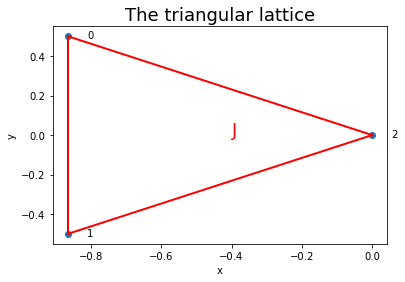

In [128]:
# Make the grid
x=[-0.866,-0.866,0]
y=[0.5,-0.5,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))

plt.annotate("J",(-0.4,0),xytext=(-0.4,0),color="r",size=18)

# Nearest-neighbors coupling
plt.plot([-0.866,0],[-0.5,0],"r",linewidth="2")
plt.plot([-0.866,0],[0.5,0],"r",linewidth="2")
plt.plot([-0.866,-0.866],[-0.5,0.5],"r",linewidth="2")

plt.title("The triangular lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

We consider a completely anti-ferromagnetic Hamiltonian on the triangle.

In [129]:
nn_list2=[(0,1),(1,2),(0,2)]
H_te=generate_Heisenberg(3,nn_list2)
mat_H_te=H_te.to_matrix()
print(mat_H_te)

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  2.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j  2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  2.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  2.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j -1.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  2.+0.j  0.+0.j  2.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j]]


#### $[H,S]=0$ ?

We remind that $[H,S^2]=0$ involves that $[H,S]=0$. Now we define the spin operators in the case of $3$ spins.

In [130]:
sx=[]
for i in range (3):
    sx.append((1.0/2.,generate_pauli([i],[],3)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (3):
    sy.append((1.0/2.,generate_pauli([i],[i],3)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

sz=[]
for i in range (3):
    sz.append((1.0/2.,generate_pauli([],[i],3)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
#print("Sz operator matrix")
#print(mat_sz)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
#print("S2 operator")
#print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
#print("S2 operator matrix")
#print(mat_s2)

Sx operator
IIX	(0.5+0j)
IXI	(0.5+0j)
XII	(0.5+0j)

Sy operator
IIY	(0.5+0j)
IYI	(0.5+0j)
YII	(0.5+0j)

Sz operator
IIZ	(0.5+0j)
IZI	(0.5+0j)
ZII	(0.5+0j)



In [131]:
if np.all(np.dot(mat_H_te,mat_s2)==np.dot(mat_s2,mat_H_te)):
    print("They commute!")
else:
    print("They don't commute!")

They commute!


#### Heisenberg Hamiltonian eigenvalues for the equilateral case

In [132]:
spins_triangle=generate_spin_operators(3)
out_te=diagonalize_H(H_te,spins_triangle)

2021-02-10 15:54:01,466:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:01,501:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.26726910200241927, 0],
       [0.0, 0],
       [-0.1991942223708597, 0],
       [-0.5345382040048385, 0],
       [0.0, 0],
       [0.3983884447417194, 0],
       [-0.5345382040048385, 0],
       [0.0, 0],
       [0.3983884447417194, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333333, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.22221343317393033, 0],
       [0.0, 0],
       [0.724943674576175, 0],
       [-0.2816038020861739, 0],
       [0.0, 0],
       [0.5294670784354234, 0],
       [0.05198507753745296, 0

Text(0.5, 1.0, 'Equilateral case - Heisenberg on triangular lattice')

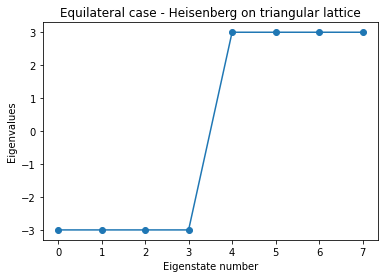

In [133]:
plt.plot(np.arange(len(out_te[0])),out_te[0],marker="o")
plt.ylabel("Eigenvalues")
plt.xlabel("Eigenstate number")
plt.title("Equilateral case - Heisenberg on triangular lattice")

#### Study of the total spin eigenfunctions

In [134]:
psi_L   = compose_two_spins('L')
psi_LC  = compose_with_center(psi_L,'L')

print("States LC - Number: ",len(psi_LC.keys()))
print_states(psi_LC)

States LC - Number:  8
State  L_j1_0_lc_0.5_-0.5
(0, 1, 1)   0.7071067811865476
(1, 0, 1)   -0.7071067811865476
 
State  L_j1_0_lc_0.5_0.5
(0, 1, 0)   0.7071067811865476
(1, 0, 0)   -0.7071067811865476
 
State  L_j1_1_lc_0.5_-0.5
(0, 1, 1)   0.408248290463863
(1, 0, 1)   0.408248290463863
(1, 1, 0)   -0.816496580927726
 
State  L_j1_1_lc_0.5_0.5
(0, 0, 1)   0.816496580927726
(0, 1, 0)   -0.408248290463863
(1, 0, 0)   -0.408248290463863
 
State  L_j1_1_lc_1.5_-1.5
(1, 1, 1)   1.0
 
State  L_j1_1_lc_1.5_-0.5
(0, 1, 1)   0.5773502691896258
(1, 0, 1)   0.5773502691896258
(1, 1, 0)   0.5773502691896257
 
State  L_j1_1_lc_1.5_0.5
(0, 0, 1)   0.5773502691896257
(0, 1, 0)   0.5773502691896258
(1, 0, 0)   0.5773502691896258
 
State  L_j1_1_lc_1.5_1.5
(0, 0, 0)   1.0
 


In [135]:
psi=[]
for v in psi_LC.values():
    # We use concatenate 4 times because the vectors have been built using np.zeros((2,2,2,2,2))
    psi.append(np.concatenate(np.concatenate(v)))


for i,key in enumerate(psi_LC.keys()):
    lab=key.split('_')
    print(i+1, ") JL=",lab[2]," J=",lab[4]," M=",lab[5])
    if np.round(np.dot(np.conjugate(np.transpose(psi[i])),psi[i]),3)==1:
        E=np.round(np.real(np.dot(np.conjugate(np.transpose(psi[i])),np.dot(mat_H_te,psi[i]))),3)
        print("<H> = ",E)

1 ) JL= 0  J= 0.5  M= -0.5
<H> =  -3.0
2 ) JL= 0  J= 0.5  M= 0.5
<H> =  -3.0
3 ) JL= 1  J= 0.5  M= -0.5
<H> =  -3.0
4 ) JL= 1  J= 0.5  M= 0.5
<H> =  -3.0
5 ) JL= 1  J= 1.5  M= -1.5
<H> =  3.0
6 ) JL= 1  J= 1.5  M= -0.5
<H> =  3.0
7 ) JL= 1  J= 1.5  M= 0.5
<H> =  3.0
8 ) JL= 1  J= 1.5  M= 1.5
<H> =  3.0


All total spin eigenfunctions are eigenstates of the Heisenberg Hamiltonian of the triangular lattice.

## Isosceles case

Text(0, 0.5, 'y')

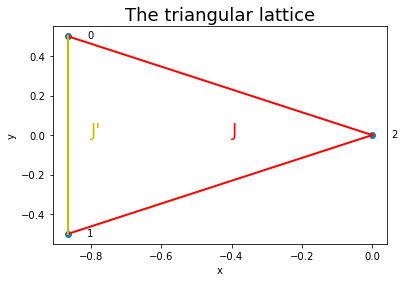

In [136]:
# Make the grid
x=[-0.866,-0.866,0]
y=[0.5,-0.5,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))

plt.annotate("J",(-0.4,0),xytext=(-0.4,0),color="r",size=18)
plt.annotate("J'",(-0.4,0),xytext=(-0.8,0),color="y",size=18)

# Nearest-neighbors coupling
plt.plot([-0.866,0],[-0.5,0],"r",linewidth="2")
plt.plot([-0.866,0],[0.5,0],"r",linewidth="2")
plt.plot([-0.866,-0.866],[-0.5,0.5],"y",linewidth="2")

plt.title("The triangular lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

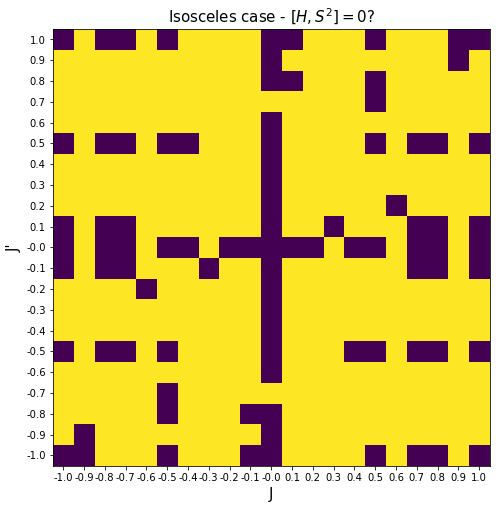

In [137]:
val=np.round(np.arange(-1.,1+1e-4,0.1),2)
M=np.zeros((len(val),len(val)))
for i in range(len(val)):
    for j in range(len(val)):
            coef=[val[i],val[j],val[j]]
            H_ti=anisotropic_Heisenberg(3,nn_list2,coef)
            mat_H_ti=H_ti.to_matrix()
             
            if np.all(np.dot(mat_H_ti,mat_s2)==np.dot(mat_s2,mat_H_ti)):
                M[len(val)-1-i,j]=0
            else:
                M[len(val)-1-i,j]=1
            
fig, ax = plt.subplots(figsize=(7,14))
im = ax.imshow(M)       
ax.set_xticks(np.arange(len(val)))
ax.set_yticks(np.arange(len(val)))
ax.set_xticklabels(np.round(val,2), fontsize=10)
ax.set_yticklabels(np.round(val[::-1],2), fontsize=10)

ax.set_xlabel("J",fontsize=15)
ax.set_ylabel("J'",fontsize=15)
        
#fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

ax.set_title("Isosceles case - $[H,S^2]=0$?", fontsize=15)
fig.tight_layout()
plt.show()

Maybe we have to focus on the region of the coupling constants where we have an anti-ferromagnetic behavior (up-right of the square).

#### Heisenberg Hamiltonian for the isosceles case ($J,J' \in \{0.7,0.8,0.9,1.0\}$)

We consider the area near $J=J'=1$.

In [138]:
eig_ti=[]
for i in [0.7,0.8,0.9,1.0]:
    for j in [0.7,0.8,0.9,1.0]:
        coef=[i,j,j]
        H_ti=anisotropic_Heisenberg(3,nn_list2,coef)
        out_ti=diagonalize_H(H_ti,spins_triangle)
        eig_ti.append(out_ti[0])

2021-02-10 15:54:03,261:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,317:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.11671180777287618, 0],
       [0.0, 0],
       [-0.31223303002324776, 0],
       [0.23342361554575217, 0],
       [0.0, 0],
       [0.6244660600464954, 0],
       [0.2334236155457522, 0],
       [0.0, 0],
       [0.6244660600464957, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.9876195351713702, 0],
       [0.0, 0],
       [0.14520814584068442, 0],
       [0.025086563363722947, 0],
       [0.0, 0],
       [0.04443262833779771, 0],
       [-0.025971356430454

2021-02-10 15:54:03,364:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,420:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.045159444004323396, 0],
       [0.0, 0],
       [0.6651353764923835, 0],
       [-0.045159444004324034, 0],
       [0.0, 0],
       [0.6651353764923836, 0],
       [0.02257972200216187, 0],
       [0.0, 0],
       [-0.3325676882461916, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666661, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666672, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.23604541752070757, 0],
       [0.0, 0],
       [0.9717420238249836, 0]], dty

2021-02-10 15:54:03,444:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,476:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0004339785195512046, 0],
       [0.0, 0],
       [0.666666525413636, 0],
       [0.00043397851955124796, 0],
       [0.0, 0],
       [0.666666525413634, 0],
       [-0.00021698925977561796, 0],
       [0.0, 0],
       [-0.3333332627068175, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666671, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333315, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0000000000000002, 0]], dtype=object),
 

2021-02-10 15:54:03,492:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,542:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666677, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333336, 0]], dtype=object),
                   array([[0.16957752380441438, 0],
       [0.0, 0],
       [0.6447386353126416, 0],
       [0.16957752380441476, 0],
       [0.0, 0],
       [0.6447386353126422, 0],
       [-0.08478876190220727, 0],
       [0.0, 0],
       [-0.32236931765632093, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   arr

2021-02-10 15:54:03,564:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,607:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.3414628513016036, 0],
       [0.0, 0],
       [0.9398952713898387, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999998, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666663, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.666666666666667, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333334, 0]], dtype=object),
                   array([[0.6358065832050808, 0],
       [0.0, 0],
    

2021-02-10 15:54:03,626:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,667:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[-0.4247311930787846, 0],
       [0.0, 0],
       [-0.8943454079064137, 0],
       [-0.1173373697077647, 0],
       [0.0, 0],
       [0.07526635255067493, 0],
       [0.12778080654387072, 0],
       [0.0, 0],
       [-0.05846199989392645, 0]], dtype=object),
                   array([[0.3761005053412419, 0],
       [0.0, 0],
       [0.800718649073586, 0],
       [0.18607626955986326, 0],
       [0.0, 0],
       [0.3342427429142566, 0],
       [-0.12508768425328654

2021-02-10 15:54:03,690:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,724:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666664, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666673, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333337, 0]], dtype=object),
                   array([[-0.35252040806401796, 0],
       [0.0, 0],
       [0.5658390286493356, 0],
       [-0.35252040806401874, 0],
       [0.0, 0],
       [0.565839028649334, 0],
       [0.17626020403200912, 0],
       [0.0, 0],
       [-0.28291951432466766, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999998, 0]], dtype=object),
     

2021-02-10 15:54:03,741:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,779:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666655, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666682, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333336, 0]], dtype=object),
                   array([[-0.0712996736209689, 0],
       [0.0, 0],
       [0.662842968572487, 0],
       [-0.07129967362096906, 0],
       [0.0, 0],
       [0.662842968572488, 0],
       [0.035649836810484475, 0],
       [0.0, 0],
       [-0.3314214842862435, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999999, 0]], dtype=object),
        

2021-02-10 15:54:03,802:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,846:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6031368735429438, 0],
       [0.0, 0],
       [0.7976377070906586, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666661, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666676, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333354, 0]], dtype=object),
                   array([[-0.20389886784488095, 0],
       [0.0, 0],
       [0.63472

2021-02-10 15:54:03,862:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,901:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.04242337549308686, 0],
       [0.0, 0],
       [0.9990997233568693, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666659, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666679, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333335, 0]], dtype=object),
                   array([[0.10771661955196227, 0],
       [0.0, 0],
       [0.6579069

2021-02-10 15:54:03,927:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:03,965:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.17316266895287058, 0],
       [0.0, 0],
       [-0.2848259138355037, 0],
       [0.34632533790574105, 0],
       [0.0, 0],
       [0.5696518276710072, 0],
       [0.34632533790574105, 0],
       [0.0, 0],
       [0.5696518276710072, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.1509151236185824, 0],
       [0.0, 0],
       [0.7448070619397972, 0],
       [-0.10872023227369565, 0],
       [0.0, 0],
       [-0.30852058948041117, 0],
       [0.2427500153263080

2021-02-10 15:54:03,985:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:04,024:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.4214637180754671, 0],
       [0.0, 0],
       [0.5165392325762374, 0],
       [-0.4214637180754673, 0],
       [0.0, 0],
       [0.516539232576236, 0],
       [0.21073185903773362, 0],
       [0.0, 0],
       [-0.2582696162881182, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666661, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666672, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333326, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   arra

2021-02-10 15:54:04,041:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:04,091:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.10328122565736506, 0],
       [0.0, 0],
       [0.994652194702607, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666663, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333326, 0]], dtype=object),
                   array([[-0.2030828859876484, 0],
       [0.0, 0],
       [0.634981

2021-02-10 15:54:04,109:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:04,154:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999999, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.12444566549919797, 0],
       [0.0, 0],
       [0.9922264239267474, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666674, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666663, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333335, 0]], dtype=object),
                   array([[0.12079194859874082, 0],
       [0.0, 0],
  

2021-02-10 15:54:04,174:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:04,216:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.32810269025704564, 0],
       [0.0, 0],
       [0.9446420616540898, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   array([[0.3334907687408667, 0],
       [0.0, 0],
       [0.5772593451898993, 0],
       [0.3334907687408665, 0],
       [0.0, 0],
       [0.5772593451898975, 0],
       [-0.1667453843704333, 0],
       [0.0, 0],
       [-0.28862967259494926, 0]], dtype=object),
                   array([[0.0, 0],
    

2021-02-10 15:54:04,233:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:04,284:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.26726910200241927, 0],
       [0.0, 0],
       [-0.1991942223708597, 0],
       [-0.5345382040048385, 0],
       [0.0, 0],
       [0.3983884447417194, 0],
       [-0.5345382040048385, 0],
       [0.0, 0],
       [0.3983884447417194, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333333, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.22221343317393033, 0],
       [0.0, 0],
       [0.724943674576175, 0],
       [-0.2816038020861739, 0],
       [0.0, 0],
       [0.5294670784354234, 0],
       [0.05198507753745296, 0

In [139]:
c=0
print("Eigenvalues of H(J,J') s.t. [H,S]!=0","\n")
for i in [0.7,0.8,0.9,1.0]:
    for j in [0.7,0.8,0.9,1.0]:
        if c==15:
            break
        print("Eigenvalues of H with J =",j,", J' =",i," : ",eig_ti[c])
        c+=1

Eigenvalues of H(J,J') s.t. [H,S]!=0 

Eigenvalues of H with J = 0.7 , J' = 0.7  :  [-2.1 -2.1 -2.1 -2.1  2.1  2.1  2.1  2.1]
Eigenvalues of H with J = 0.8 , J' = 0.7  :  [-2.5 -2.5 -2.1 -2.1  2.3  2.3  2.3  2.3]
Eigenvalues of H with J = 0.9 , J' = 0.7  :  [-2.9 -2.9 -2.1 -2.1  2.5  2.5  2.5  2.5]
Eigenvalues of H with J = 1.0 , J' = 0.7  :  [-3.3 -3.3 -2.1 -2.1  2.7  2.7  2.7  2.7]
Eigenvalues of H with J = 0.7 , J' = 0.8  :  [-2.4 -2.4 -2.  -2.   2.2  2.2  2.2  2.2]
Eigenvalues of H with J = 0.8 , J' = 0.8  :  [-2.4 -2.4 -2.4 -2.4  2.4  2.4  2.4  2.4]
Eigenvalues of H with J = 0.9 , J' = 0.8  :  [-2.8 -2.8 -2.4 -2.4  2.6  2.6  2.6  2.6]
Eigenvalues of H with J = 1.0 , J' = 0.8  :  [-3.2 -3.2 -2.4 -2.4  2.8  2.8  2.8  2.8]
Eigenvalues of H with J = 0.7 , J' = 0.9  :  [-2.7 -2.7 -1.9 -1.9  2.3  2.3  2.3  2.3]
Eigenvalues of H with J = 0.8 , J' = 0.9  :  [-2.7 -2.7 -2.3 -2.3  2.5  2.5  2.5  2.5]
Eigenvalues of H with J = 0.9 , J' = 0.9  :  [-2.7 -2.7 -2.7 -2.7  2.7  2.7  2.7  2.7]
Eige

As we expected, the eigenvalues of the isosceles case are different from those coming from the equilateral case. Moreover, we see that degeneracy of the eigenvalues changes. The case with $J=1=J'$ is the equilateral one.

## Scalene case

Text(0, 0.5, 'y')

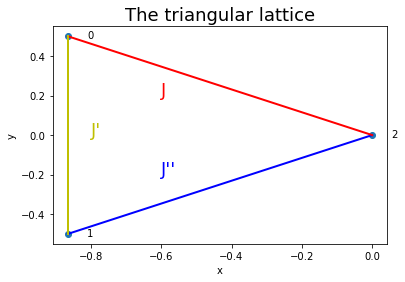

In [140]:
# Make the grid
x=[-0.866,-0.866,0]
y=[0.5,-0.5,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))

plt.annotate("J",(-0.6,0.2),xytext=(-0.6,0.2),color="r",size=18)
plt.annotate("J'",(-0.8,0),xytext=(-0.8,0),color="y",size=18)
plt.annotate("J''",(-0.6,-0.2),xytext=(-0.6,-0.2),color="b",size=18)

# Nearest-neighbors coupling
plt.plot([-0.866,0],[-0.5,0],"b",linewidth="2")
plt.plot([-0.866,0],[0.5,0],"r",linewidth="2")
plt.plot([-0.866,-0.866],[-0.5,0.5],"y",linewidth="2")

plt.title("The triangular lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

We consider $J,J',J'' \in [-1,1]$

In [141]:
val=np.round(np.arange(-1.,1+1e-4,0.1),2)
#print("[H,S]=0 if:")
count=0
for i in range(len(val)):
    for j in range(len(val)):
        for k in range(len(val)):
            coef=[val[i],val[k],val[j]]
            H_ts=anisotropic_Heisenberg(3,nn_list2,coef)
            mat_H_ts=H_ts.to_matrix()
             
            if np.all(np.dot(mat_H_ts,mat_s2)==np.dot(mat_s2,mat_H_ts)):
                #print("J = ",val[j]," J' = ",val[i]," J'' = ",val[k])
                count+=1
print("[H,S]=0 in ",count,"/",len(val)**3," cases")

[H,S]=0 in  645 / 9261  cases


#### Heisenberg Hamiltonian for the scalene case ($J,J',J'' \in \{0.8,0.9,1.0\}$)

In [142]:
eig_ts=[]
comm_ts=[1]*27
c=0
for i in [0.8,0.9,1.0]:
    for j in [0.8,0.9,1.0]:
        for k in [0.8,0.9,1.0]:
            coef=[i,k,j]
            H_ts=anisotropic_Heisenberg(3,nn_list2,coef)
            mat_H_ts=H_ts.to_matrix()
            if np.all(np.dot(mat_H_ts,mat_s2)==np.dot(mat_s2,mat_H_ts)):
                comm_ts[c]=0
            out_ts=diagonalize_H(H_ts,spins_triangle)
            eig_ts.append(out_ts[0])
            c+=1

2021-02-10 15:54:22,419:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:22,506:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[-0.4247311930787846, 0],
       [0.0, 0],
       [-0.8943454079064137, 0],
       [-0.1173373697077647, 0],
       [0.0, 0],
       [0.07526635255067493, 0],
       [0.12778080654387072, 0],
       [0.0, 0],
       [-0.05846199989392645, 0]], dtype=object),
                   array([[0.3761005053412419, 0],
       [0.0, 0],
       [0.800718649073586, 0],
       [0.18607626955986326, 0],
       [0.0, 0],
       [0.3342427429142566, 0],
       [-0.12508768425328654

2021-02-10 15:54:22,550:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:22,607:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-1.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.217409750667734, 0],
       [0.0, 0],
       [0.9760804271752374, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.09009795778900101, 0],
       [0.0, 0],
       [-0.32092595581124783, 0],
       [0.18019591557800346, 0],
       [0.0, 0],
       [0.6418519116224948, 0],
       [0.18019591557800083, 0],
       [0.0, 0],
       [0.6418519116224941, 0]], dtype=object),
                   array([[0.0, 0],
   

2021-02-10 15:54:22,667:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:22,736:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.7208714955921887, 0],
       [0.0, 0],
       [0.6930687461159108, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.30991308617385555, 0],
       [0.0, 0],
       [-0.9507648915574219, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[-0.09663079881796757, 0],
       [0.0, 0],
       [-0.31901974833999336, 0],
       [0.19326159763593495, 0],
       [0.0, 0],
       [0.6380394966799867, 0],
       [0.1932615976359351, 0],
       [0.0, 0],
       [0.6380394966799866, 0]], dtype=object),
       

2021-02-10 15:54:22,761:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:22,833:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.7160867588506241, 0],
       [0.0, 0],
       [-0.6980112848649427, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.12875702371072711, 0],
       [0.0, 0],
       [0.9916761713609716, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666667, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333327, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666659, 0]], dtype=object),
                   array([[0.6544835548004327, 0],
     

2021-02-10 15:54:22,870:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:22,917:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666664, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666673, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333337, 0]], dtype=object),
                   array([[-0.35252040806401796, 0],
       [0.0, 0],
       [0.5658390286493356, 0],
       [-0.35252040806401874, 0],
       [0.0, 0],
       [0.565839028649334, 0],
       [0.17626020403200912, 0],
       [0.0, 0],
       [-0.28291951432466766, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999998, 0]], dtype=object),
     

2021-02-10 15:54:22,966:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,034:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.9106836025229588, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.3333333333333344, 0],
       [0.0, 0],
       [0.0, 0],
       [0.24401693585629317, 0]], dtype=object),
                   array([[-0.8016582880918077, 0],
       [0.0, 0],
       [0.43207477713690523, 0],
       [-0.2934272985959465, 0],
       [0.0, 0],
       [0.1581503447666074, 0],
       [0.21480369089991663, 0],
       [0.0, 0],
       [-0.11577408760369098, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.24401693585629275, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.33333333333333365, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9106836025

2021-02-10 15:54:23,067:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,131:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.0006851613412352586, 0],
       [0.0, 0],
       [-0.9999997652769407, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.35056452747241285, 0],
       [0.0, 0],
       [0.9365385801332714, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666654, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333326, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666676, 0]], dtype=object),
                   array([[-0.0999177784798835, 0]

2021-02-10 15:54:23,166:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,216:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.006422237048222225, 0],
       [0.0, 0],
       [0.3332714598977957, 0],
       [0.017545877913994517, 0],
       [0.0, 0],
       [0.9105145611534297, 0],
       [-0.004701403817549873, 0],
       [0.0, 0],
       [-0.24397164135784022, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.33333333333333154, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9106836025229599, 0],
       [0.0, 0],
       [0.0, 0],
       [0.24401693585629142, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.33333333333333454, 0],
       [0.0, 0],
       [0.0, 0],
       [0.24401693585629308, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.910683

2021-02-10 15:54:23,249:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,330:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666655, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666682, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333336, 0]], dtype=object),
                   array([[-0.0712996736209689, 0],
       [0.0, 0],
       [0.662842968572487, 0],
       [-0.07129967362096906, 0],
       [0.0, 0],
       [0.662842968572488, 0],
       [0.035649836810484475, 0],
       [0.0, 0],
       [-0.3314214842862435, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999999, 0]], dtype=object),
        

2021-02-10 15:54:23,359:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,419:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.04242337549308686, 0],
       [0.0, 0],
       [0.9990997233568693, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666659, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666679, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333335, 0]], dtype=object),
                   array([[0.10771661955196227, 0],
       [0.0, 0],
       [0.6579069

2021-02-10 15:54:23,446:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,516:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666676, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333335, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666661, 0]], dtype=object),
                   array([[0.6320674722382232, 0],
       [0.0, 0],
       [0.2119791380839796, 0],
       [-0.3160337361191116, 0],
       [0.0, 0],
       [-0.10598956904198986, 0],
       [0.632067472238224, 0],
       [0.0, 0],
       [0.21197913808397867, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999998, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
         

2021-02-10 15:54:23,561:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,621:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.9106836025229589, 0],
       [0.0, 0],
       [0.0, 0],
       [0.24401693585629256, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.33333333333333365, 0]], dtype=object),
                   array([[0.44897541999989715, 0],
       [0.0, 0],
       [0.7923166640555469, 0],
       [-0.12030260121039679, 0],
       [0.0, 0],
       [-0.21230061028340536, 0],
       [0.1643364093947507, 0],
       [0.0, 0],
       [0.29000802688607147, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.24401693585629264, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.910683602522959, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.33333333333

2021-02-10 15:54:23,668:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,733:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.06489259163071656, 0],
       [0.0, 0],
       [-0.32695575031272983, 0],
       [-0.12978518326143496, 0],
       [0.0, 0],
       [0.6539115006254617, 0],
       [-0.12978518326143135, 0],
       [0.0, 0],
       [0.6539115006254579, 0]], dtype=object),
                   array([[0.7482031383563024, 0],
       [0.0, 0],
       [-0.6634697157774266, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype

2021-02-10 15:54:23,756:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,820:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.17316266895287058, 0],
       [0.0, 0],
       [-0.2848259138355037, 0],
       [0.34632533790574105, 0],
       [0.0, 0],
       [0.5696518276710072, 0],
       [0.34632533790574105, 0],
       [0.0, 0],
       [0.5696518276710072, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.1509151236185824, 0],
       [0.0, 0],
       [0.7448070619397972, 0],
       [-0.10872023227369565, 0],
       [0.0, 0],
       [-0.30852058948041117, 0],
       [0.2427500153263080

2021-02-10 15:54:23,868:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:23,928:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.451044474532008, 0],
       [0.0, 0],
       [0.8925014745053058, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.9999999999999999, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333333, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[-0.23765901174958687, 0],
       [0.0, 0],
  

2021-02-10 15:54:23,965:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,038:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.2440169358562922, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9106836025229597, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.33333333333333287, 0]], dtype=object),
                   array([[-0.04967782139318077, 0],
       [0.0, 0],
       [-0.23890663248708843, 0],
       [0.18540015344868244, 0],
       [0.0, 0],
       [0.8916116907070035, 0],
       [0.06786116602775105, 0],
       [0.0, 0],
       [0.32635252910995516, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.9106836025229591, 0],
       [0.0, 0],
       [0.0, 0],
       [0.2440169358562925, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.33333333333

2021-02-10 15:54:24,082:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,127:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.4783708317202694, 0],
       [0.0, 0],
       [0.87815792848397, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666665, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333332, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666667, 0]], dtype=object),
                   array([[0.18499201936821333, 0],
       [0.0, 0],
       [0.640486063

2021-02-10 15:54:24,160:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,236:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.4214637180754671, 0],
       [0.0, 0],
       [0.5165392325762374, 0],
       [-0.4214637180754673, 0],
       [0.0, 0],
       [0.516539232576236, 0],
       [0.21073185903773362, 0],
       [0.0, 0],
       [-0.2582696162881182, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666661, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666672, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333326, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   arra

2021-02-10 15:54:24,271:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,334:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9999999999999999, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.12444566549919797, 0],
       [0.0, 0],
       [0.9922264239267474, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666674, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666663, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333335, 0]], dtype=object),
                   array([[0.12079194859874082, 0],
       [0.0, 0],
  

2021-02-10 15:54:24,362:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,418:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.014033471486972145, 0],
       [0.0, 0],
       [0.3330377948358644, 0],
       [-0.010273214135032785, 0],
       [0.0, 0],
       [-0.24380058666055282, 0],
       [0.038340157108976904, 0],
       [0.0, 0],
       [0.9098761763322821, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.33333333333333165, 0],
       [0.0, 0],
       [0.0, 0],
       [0.2440169358562913, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9106836025229597, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.3333333333333327, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.9106836025229598, 0],
       [0.0, 0],
       [0.0, 0],
       [0.244016935

2021-02-10 15:54:24,451:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,500:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[-0.3282250195282701, 0],
       [0.0, 0],
       [0.5802695761455279, 0],
       [0.16411250976413508, 0],
       [0.0, 0],
       [-0.29013478807276444, 0],
       [-0.32822501952827043, 0],
       [0.0, 0],
       [0.5802695761455293, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666659, 0],
       [0.0, 0],
       [0.0, 0],
       [0.3333333333333335, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666679, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0000000000000002, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
      

2021-02-10 15:54:24,538:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,589:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.24401693585629264, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.33333333333333354, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.910683602522959, 0]], dtype=object),
                   array([[-0.034781971036147497, 0],
       [0.0, 0],
       [-0.24152531849794706, 0],
       [0.04751305602907199, 0],
       [0.0, 0],
       [0.3299297207253224, 0],
       [0.12980808309429298, 0],
       [0.0, 0],
       [0.9013847599485922, 0]], dtype=object),
                   array([[-0.6341506998000108, 0],
       [0.0, 0],
       [0.6536034836560691, 0],
       [-0.23211526595448437, 0],
       [0.0, 0],
       [0.23923547902013098, 0],
       [0.1699201678910

2021-02-10 15:54:24,622:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,679:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.32810269025704564, 0],
       [0.0, 0],
       [0.9446420616540898, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-1.0, 0]], dtype=object),
                   array([[0.3334907687408667, 0],
       [0.0, 0],
       [0.5772593451898993, 0],
       [0.3334907687408665, 0],
       [0.0, 0],
       [0.5772593451898975, 0],
       [-0.1667453843704333, 0],
       [0.0, 0],
       [-0.28862967259494926, 0]], dtype=object),
                   array([[0.0, 0],
    

2021-02-10 15:54:24,707:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,783:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [-0.6666666666666669, 0],
       [0.0, 0],
       [0.0, 0],
       [0.33333333333333337, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666669, 0]], dtype=object),
                   array([[-0.28503639520336943, 0],
       [0.0, 0],
       [0.6026596866009137, 0],
       [0.14251819760168494, 0],
       [0.0, 0],
       [-0.30132984330045737, 0],
       [-0.28503639520337043, 0],
       [0.0, 0],
       [0.6026596866009156, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.2955788306297034, 0],
       [0.0, 0],
       [0.9553183526362177, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtyp

2021-02-10 15:54:24,819:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,887:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333333, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.16354840183550118, 0],
       [0.0, 0],
       [-0.29045314831856195, 0],
       [-0.3270968036710023, 0],
       [0.0, 0],
       [0.5809062966371239, 0],
       [-0.32709680367100236, 0],
       [0.0, 0],
       [0.580906296637124, 0]], dtype=object),
                   array([[-0.8815470352054493, 0],
       [0.0, 0],
       [0.47209620282362225, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=

2021-02-10 15:54:24,913:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:24,966:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.04462031518580083, 0],
       [0.0, 0],
       [-0.33033337491665987, 0],
       [-0.08924063037160362, 0],
       [0.0, 0],
       [0.6606667498333194, 0],
       [-0.08924063037159952, 0],
       [0.0, 0],
       [0.6606667498333216, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333333, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [-0.9999999999999998, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0],
       [0.0, 0]], dtype=object),
     

2021-02-10 15:54:25,003:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: SciPy doesn't support to get all eigenvalues, using NumPy instead.
2021-02-10 15:54:25,051:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'aux_ops': [   array([[0.26726910200241927, 0],
       [0.0, 0],
       [-0.1991942223708597, 0],
       [-0.5345382040048385, 0],
       [0.0, 0],
       [0.3983884447417194, 0],
       [-0.5345382040048385, 0],
       [0.0, 0],
       [0.3983884447417194, 0]], dtype=object),
                   array([[0.0, 0],
       [0.0, 0],
       [0.3333333333333333, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0],
       [0.0, 0],
       [0.0, 0],
       [-0.6666666666666666, 0]], dtype=object),
                   array([[0.22221343317393033, 0],
       [0.0, 0],
       [0.724943674576175, 0],
       [-0.2816038020861739, 0],
       [0.0, 0],
       [0.5294670784354234, 0],
       [0.05198507753745296, 0

In [143]:
c=0
print("Eigenvalues of H(J,J',J'') s.t. [H,S]!=0","\n")
for i in [0.8,0.9,1.0]:
    for j in [0.8,0.9,1.0]:
        for k in [0.8,0.9,1.0]:
            if comm_ts[c]==1:
                print("J =",j,", J' =",i,", J''= ",k," : ",np.round(eig_ts[c],2))
            c+=1

Eigenvalues of H(J,J',J'') s.t. [H,S]!=0 

J = 0.8 , J' = 0.8 , J''=  0.8  :  [-2.4 -2.4 -2.4 -2.4  2.4  2.4  2.4  2.4]
J = 0.8 , J' = 0.8 , J''=  0.9  :  [-2.7 -2.7 -2.3 -2.3  2.5  2.5  2.5  2.5]
J = 0.8 , J' = 0.8 , J''=  1.0  :  [-3.  -3.  -2.2 -2.2  2.6  2.6  2.6  2.6]
J = 0.9 , J' = 0.8 , J''=  0.8  :  [-2.7 -2.7 -2.3 -2.3  2.5  2.5  2.5  2.5]
J = 0.9 , J' = 0.8 , J''=  0.9  :  [-2.8 -2.8 -2.4 -2.4  2.6  2.6  2.6  2.6]
J = 0.9 , J' = 0.8 , J''=  1.0  :  [-3.05 -3.05 -2.35 -2.35  2.7   2.7   2.7   2.7 ]
J = 1.0 , J' = 0.8 , J''=  0.8  :  [-3.  -3.  -2.2 -2.2  2.6  2.6  2.6  2.6]
J = 1.0 , J' = 0.8 , J''=  0.9  :  [-3.05 -3.05 -2.35 -2.35  2.7   2.7   2.7   2.7 ]
J = 1.0 , J' = 0.8 , J''=  1.0  :  [-3.2 -3.2 -2.4 -2.4  2.8  2.8  2.8  2.8]
J = 0.8 , J' = 0.9 , J''=  0.8  :  [-2.7 -2.7 -2.3 -2.3  2.5  2.5  2.5  2.5]
J = 0.8 , J' = 0.9 , J''=  0.9  :  [-2.8 -2.8 -2.4 -2.4  2.6  2.6  2.6  2.6]
J = 0.8 , J' = 0.9 , J''=  1.0  :  [-3.05 -3.05 -2.35 -2.35  2.7   2.7   2.7   2.7 ]
J = 0.9 ,